In [1]:
import os
import random
import itertools
import re

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# サンプリング
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 特徴量選択
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy
from libraries.mrmr import mrmr

# 学習中
import optuna
from tqdm import tqdm
from sklearn.model_selection import learning_curve, cross_validate, cross_val_score

# 評価指標
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings


# config python file
import config

SEED = config.SEED


from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

# 目的
遺伝子学的分類に基づいた、予後の2値分類を実施する。  
分類はCLAUDIN_SUBTYPEに基づいて実施。  
予後は5年、10年、15年の3つの年次に分けている。Trueで死亡であることに注意すること。

# データ読み込み
読み込み元：
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/claudin_subtype_chi2"

サブタイプ毎のデータを使用 

In [2]:
X_dict = pickle_load(
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_dict.pickle"
)
y_dict = pickle_load(
    config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y_dict.pickle"
)

# モデルのトレーニング

## ベースモデルの学習結果

各特徴量選択されたdfを用いて基本的な2値分類モデルを学習する

### chi2

#### chi2 (basic)

In [3]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    # compare_bcmsは内部でk分割交差検証を行うので、train_test_splitをしなくて良い
    X_train = X_dict["basic"]["chi2"]["train"][prognosis_Xlabel]
    y_train = y_dict["basic"]["chi2"]["train"][prognosis_ylabel]

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.ones(len(y_train))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display("ラベル比率：", y_train.value_counts())

    save_dir = (
        config.TABLES_MODELS_PROGNOSIS_CROSS_DIR + "/scores_base-model/basic/chi2"
    )
    make_dir(save_dir)
    display(
        compare_bcms(X_train, y_train, save_path=save_dir + "/{0:0=2}.csv".format(year))
    )

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.814)
使用特徴量： Index(['NPI', 'ER_STATUS', 'HER2_STATUS', 'PR_STATUS',
       'LYMPH_NODES_EXAMINED_POSITIVE', 'TUMOR_SIZE', 'TTYH1', 'GAL', 'GLRB',
       'C14orf45',
       ...
       'C1orf106', 'WNK4', 'AZGP1', 'NOSTRIN', 'MYB', 'PROM1', 'CEP55',
       'MCM10', 'TFF3', 'SLC39A6'],
      dtype='object', length=207)
学習サンプルサイズ： (1293, 207)


'ラベル比率：'

0    1053
1     240
Name: OS_05years, dtype: int64

11it [00:49,  4.54s/it]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Naive Bayes                       0.718999  0.716130  0.469506  0.461882
Polynomial SVM                    0.969665  0.805856  0.911919  0.436349
Linear SVM                        0.907536  0.785766  0.721758  0.383642
Logistic Regression               0.896193  0.791199  0.677585  0.362413
Nearest Neighbors                 0.857952  0.800441  0.535265  0.334453
AdaBoost                          0.901176  0.784222  0.695463  0.319476
Decision Tree                     0.880984  0.779606  0.626790  0.301716
RBF SVM                           0.830970  0.820561  0.190934  0.133645
Random Forest                     0.865084  0.816685  0.428610  0.083074
Quadratic Discriminant Analysis   1.000000  0.814383  1.000000  0.000000
Sigmoid SVM                       0.814385  0.814383  0.000000  0.000000

----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.644)
使用特徴量： Index(['NPI', 'ER_STATUS', 'HER2_STATUS', 'PR_STATUS',
       'LYMPH_NODES_EXAMINED_POSITIVE', 'TUMOR_SIZE', 'TAT', 'FGFR4', 'CDCA5',
       'MELK', 'AGTR1', 'GLYATL2', 'KRT81', 'ADCY1', 'AFF3', 'SERPINA1',
       'CIDEC', 'RTN1', 'STC2', 'TFF1', 'TUBA3D', 'CDC20', 'S100P', 'GFRA1',
       'CALML5', 'CAPN8', 'SUSD3', 'TCN1', 'MAPT', 'PLIN4', 'LRP2', 'SOX11',
       'TGFBR3', 'CYP4X1', 'CCDC74A', 'SERPINA5', 'ESR1', 'CFB', 'SLC7A2',
       'CLIC6', 'PIP', 'U79293', 'BCL2', 'UBE2C', 'C1orf64', 'RERG', 'SEC14L2',
       'FGD3', 'AGR3', 'ZNF385B', 'TMEM26', 'CCNB2', 'S100A9', 'AURKA',
       'SCUBE2', 'GRB7', 'ANKRD30A', 'PDZK1', 'PGR', 'S100A8', 'SERPINA11',
       'SERPINA3', 'LOC389033', 'NAT1', 'IGF1R', 'BEX1', 'MAOA', 'CBX2',
       'C6orf126', 'SNAR-A3', 'C1orf106', 'SLC39A6'],
      dtype='object')
学習サンプルサイズ： (1036, 72)


'ラベル比率：'

0    667
1    369
Name: OS_10years, dtype: int64

11it [00:18,  1.71s/it]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Naive Bayes                       0.672245  0.669007  0.578489  0.575784
Logistic Regression               0.763407  0.721145  0.624796  0.562318
Polynomial SVM                    0.832583  0.732739  0.727812  0.557652
Linear SVM                        0.766409  0.721107  0.619491  0.547057
Quadratic Discriminant Analysis   0.889425  0.677735  0.850491  0.544198
Nearest Neighbors                 0.800408  0.706656  0.691687  0.537686
Random Forest                     0.838805  0.735586  0.732779  0.536396
Decision Tree                     0.808988  0.682571  0.715666  0.530253
RBF SVM                           0.756651  0.732636  0.571445  0.527432
AdaBoost                          0.828935  0.672862  0.742440  0.503118
Sigmoid SVM                       0.643822  0.643820  0.000000  0.000000

----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.537)
使用特徴量： Index(['NPI', 'HER2_STATUS', 'PR_STATUS', 'LYMPH_NODES_EXAMINED_POSITIVE',
       'TUMOR_SIZE', 'TAT', 'AGTR1', 'GLYATL2', 'KRT81', 'STC2', 'TUBA3D',
       'S100P', 'CALML5', 'SUSD3', 'CYP4F22', 'NDP', 'BMPR1B', 'MAPT', 'ESR1',
       'SLC7A2', 'NCCRP1', 'CLIC6', 'BCL2', 'UBE2C', 'LCN2', 'FGD3', 'S100A9',
       'SCUBE2', 'ANKRD30A', 'PDZK1', 'S100A8', 'DNALI1', 'LOC389033', 'NAT1',
       'GSTM2', 'ANKRD30BP3', 'BEX1', 'SNAR-A3', 'C1orf106', 'CLEC3A'],
      dtype='object')
学習サンプルサイズ： (792, 40)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

11it [00:08,  1.31it/s]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Random Forest                     0.822952  0.664051  0.842400  0.702606
Linear SVM                        0.721659  0.672832  0.744758  0.699055
Sigmoid SVM                       0.536616  0.536614  0.698439  0.698420
RBF SVM                           0.704685  0.662816  0.733509  0.695924
Polynomial SVM                    0.759119  0.674114  0.774978  0.691150
Logistic Regression               0.720257  0.669082  0.741244  0.688532
Quadratic Discriminant Analysis   0.811726  0.650222  0.820621  0.666334
Naive Bayes                       0.651796  0.649003  0.655358  0.651640
Nearest Neighbors                 0.735408  0.624984  0.754674  0.646885
AdaBoost                          0.804153  0.608592  0.818674  0.634408
Decision Tree                     0.793634  0.594668  0.806099  0.616077

#### chi2 (immunity)

In [4]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    # compare_bcmsは内部でk分割交差検証を行うので、train_test_splitをしなくて良い
    X_train = X_dict["immunity"]["chi2"]["train"][prognosis_Xlabel]
    y_train = y_dict["immunity"]["chi2"]["train"][prognosis_ylabel]

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.ones(len(y_train))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display("ラベル比率：", y_train.value_counts())
    save_dir = (
        config.TABLES_MODELS_PROGNOSIS_CROSS_DIR + "/scores_base-model/immunity/chi2"
    )
    make_dir(save_dir)
    display(
        compare_bcms(X_train, y_train, save_path=save_dir + "/{0:0=2}.csv".format(year))
    )

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.814)
使用特徴量： Index(['ER_STATUS', 'HER2_STATUS', 'PR_STATUS', 'TTYH1', 'GAL', 'GLRB',
       'C14orf45', 'FGFR4', 'CGNL1', 'CDCA5',
       ...
       'C1orf106', 'WNK4', 'AZGP1', 'NOSTRIN', 'MYB', 'PROM1', 'CEP55',
       'MCM10', 'TFF3', 'SLC39A6'],
      dtype='object', length=204)
学習サンプルサイズ： (1293, 204)


'ラベル比率：'

0    1053
1     240
Name: OS_05years, dtype: int64

11it [00:43,  3.95s/it]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Naive Bayes                       0.717453  0.713804  0.462050  0.456827
Polynomial SVM                    0.995617  0.754049  0.988036  0.335612
Nearest Neighbors                 0.845664  0.792713  0.476325  0.315333
Logistic Regression               0.870155  0.775742  0.577636  0.306584
Linear SVM                        0.886139  0.764150  0.633715  0.280423
Decision Tree                     0.877803  0.771085  0.597498  0.224101
AdaBoost                          0.886911  0.762546  0.630165  0.215992
Random Forest                     0.850820  0.814383  0.327568  0.008000
Quadratic Discriminant Analysis   1.000000  0.814383  1.000000  0.000000
RBF SVM                           0.814385  0.814383  0.000000  0.000000
Sigmoid SVM                       0.814385  0.814383  0.000000  0.000000

----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.644)
使用特徴量： Index(['ER_STATUS', 'HER2_STATUS', 'PR_STATUS', 'TAT', 'FGFR4', 'CDCA5',
       'MELK', 'AGTR1', 'GLYATL2', 'KRT81', 'ADCY1', 'AFF3', 'SERPINA1',
       'CIDEC', 'RTN1', 'STC2', 'TFF1', 'TUBA3D', 'CDC20', 'S100P', 'GFRA1',
       'CALML5', 'CAPN8', 'SUSD3', 'TCN1', 'MAPT', 'PLIN4', 'LRP2', 'SOX11',
       'TGFBR3', 'CYP4X1', 'CCDC74A', 'SERPINA5', 'ESR1', 'CFB', 'SLC7A2',
       'CLIC6', 'PIP', 'U79293', 'BCL2', 'UBE2C', 'C1orf64', 'RERG', 'SEC14L2',
       'FGD3', 'AGR3', 'ZNF385B', 'TMEM26', 'CCNB2', 'S100A9', 'AURKA',
       'SCUBE2', 'GRB7', 'ANKRD30A', 'PDZK1', 'PGR', 'S100A8', 'SERPINA11',
       'SERPINA3', 'LOC389033', 'NAT1', 'IGF1R', 'BEX1', 'MAOA', 'CBX2',
       'C6orf126', 'SNAR-A3', 'C1orf106', 'SLC39A6'],
      dtype='object')
学習サンプルサイズ： (1036, 69)


'ラベル比率：'

0    667
1    369
Name: OS_10years, dtype: int64

11it [00:16,  1.46s/it]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Naive Bayes                       0.655728  0.652586  0.552927  0.548173
Quadratic Discriminant Analysis   0.866366  0.648721  0.824591  0.516403
Polynomial SVM                    0.924604  0.634214  0.889767  0.456436
Decision Tree                     0.806738  0.631376  0.715645  0.451991
Logistic Regression               0.712356  0.659363  0.537034  0.449793
AdaBoost                          0.800409  0.636081  0.703180  0.448623
Linear SVM                        0.716217  0.664124  0.527995  0.440123
Nearest Neighbors                 0.761047  0.638107  0.632486  0.429819
Random Forest                     0.846309  0.678622  0.740674  0.409121
RBF SVM                           0.723082  0.674720  0.464169  0.365074
Sigmoid SVM                       0.643822  0.643820  0.000000  0.000000

----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.537)
使用特徴量： Index(['HER2_STATUS', 'PR_STATUS', 'TAT', 'AGTR1', 'GLYATL2', 'KRT81', 'STC2',
       'TUBA3D', 'S100P', 'CALML5', 'SUSD3', 'CYP4F22', 'NDP', 'BMPR1B',
       'MAPT', 'ESR1', 'SLC7A2', 'NCCRP1', 'CLIC6', 'BCL2', 'UBE2C', 'LCN2',
       'FGD3', 'S100A9', 'SCUBE2', 'ANKRD30A', 'PDZK1', 'S100A8', 'DNALI1',
       'LOC389033', 'NAT1', 'GSTM2', 'ANKRD30BP3', 'BEX1', 'SNAR-A3',
       'C1orf106', 'CLEC3A'],
      dtype='object')
学習サンプルサイズ： (792, 37)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

11it [00:08,  1.34it/s]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
RBF SVM                           0.714505  0.646440  0.759798  0.702725
Sigmoid SVM                       0.536616  0.536614  0.698439  0.698420
Random Forest                     0.809201  0.632642  0.833599  0.681621
Logistic Regression               0.687430  0.642690  0.718743  0.681094
Linear SVM                        0.688972  0.636377  0.723189  0.676940
Quadratic Discriminant Analysis   0.779460  0.611218  0.796929  0.642744
Nearest Neighbors                 0.742983  0.598386  0.766837  0.634256
AdaBoost                          0.795737  0.590965  0.814791  0.627795
Polynomial SVM                    0.851152  0.580775  0.864901  0.623674
Naive Bayes                       0.618828  0.617547  0.616938  0.617022
Decision Tree                     0.779883  0.557991  0.795846  0.587679

#### chi2 (genes)

In [5]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    # compare_bcmsは内部でk分割交差検証を行うので、train_test_splitをしなくて良い
    X_train = X_dict["genes"]["chi2"]["train"][prognosis_Xlabel]
    y_train = y_dict["genes"]["chi2"]["train"][prognosis_ylabel]

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.ones(len(y_train))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display("ラベル比率：", y_train.value_counts())
    save_dir = (
        config.TABLES_MODELS_PROGNOSIS_CROSS_DIR + "/scores_base-model/genes/chi2"
    )
    make_dir(save_dir)
    display(
        compare_bcms(X_train, y_train, save_path=save_dir + "/{0:0=2}.csv".format(year))
    )

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.814)
使用特徴量： Index(['TTYH1', 'GAL', 'GLRB', 'C14orf45', 'FGFR4', 'CGNL1', 'CDCA5', 'CA12',
       'FAM83D', 'MELK',
       ...
       'C1orf106', 'WNK4', 'AZGP1', 'NOSTRIN', 'MYB', 'PROM1', 'CEP55',
       'MCM10', 'TFF3', 'SLC39A6'],
      dtype='object', length=201)
学習サンプルサイズ： (1293, 201)


'ラベル比率：'

0    1053
1     240
Name: OS_05years, dtype: int64

11it [00:46,  4.25s/it]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Naive Bayes                       0.715305  0.713798  0.460180  0.458994
Polynomial SVM                    1.000000  0.748611  1.000000  0.325256
Linear SVM                        0.884335  0.769535  0.632083  0.309255
Nearest Neighbors                 0.845664  0.790394  0.475965  0.305071
Logistic Regression               0.867578  0.772654  0.567261  0.303172
Decision Tree                     0.877115  0.774174  0.597230  0.243142
AdaBoost                          0.886911  0.762546  0.630165  0.215992
Quadratic Discriminant Analysis   1.000000  0.814383  1.000000  0.000000
RBF SVM                           0.814729  0.814383  0.003687  0.000000
Random Forest                     0.852538  0.813608  0.340332  0.000000
Sigmoid SVM                       0.814385  0.814383  0.000000  0.000000

----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.644)
使用特徴量： Index(['TAT', 'FGFR4', 'CDCA5', 'MELK', 'AGTR1', 'GLYATL2', 'KRT81', 'ADCY1',
       'AFF3', 'SERPINA1', 'CIDEC', 'RTN1', 'STC2', 'TFF1', 'TUBA3D', 'CDC20',
       'S100P', 'GFRA1', 'CALML5', 'CAPN8', 'SUSD3', 'TCN1', 'MAPT', 'PLIN4',
       'LRP2', 'SOX11', 'TGFBR3', 'CYP4X1', 'CCDC74A', 'SERPINA5', 'ESR1',
       'CFB', 'SLC7A2', 'CLIC6', 'PIP', 'U79293', 'BCL2', 'UBE2C', 'C1orf64',
       'RERG', 'SEC14L2', 'FGD3', 'AGR3', 'ZNF385B', 'TMEM26', 'CCNB2',
       'S100A9', 'AURKA', 'SCUBE2', 'GRB7', 'ANKRD30A', 'PDZK1', 'PGR',
       'S100A8', 'SERPINA11', 'SERPINA3', 'LOC389033', 'NAT1', 'IGF1R', 'BEX1',
       'MAOA', 'CBX2', 'C6orf126', 'SNAR-A3', 'C1orf106', 'SLC39A6'],
      dtype='object')
学習サンプルサイズ： (1036, 66)


'ラベル比率：'

0    667
1    369
Name: OS_10years, dtype: int64

11it [00:17,  1.61s/it]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Naive Bayes                       0.653582  0.649673  0.552643  0.547494
Quadratic Discriminant Analysis   0.858966  0.646789  0.815511  0.510101
Logistic Regression               0.710854  0.664180  0.531830  0.458369
AdaBoost                          0.800409  0.636081  0.703180  0.448623
Decision Tree                     0.806417  0.626568  0.714469  0.443552
Linear SVM                        0.717612  0.667084  0.528050  0.440409
Nearest Neighbors                 0.761797  0.640049  0.634666  0.436009
Random Forest                     0.848562  0.687332  0.744710  0.435460
Polynomial SVM                    0.983054  0.592634  0.975874  0.429296
RBF SVM                           0.759869  0.681507  0.570474  0.411485
Sigmoid SVM                       0.643822  0.643820  0.000000  0.000000

----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.537)
使用特徴量： Index(['TAT', 'AGTR1', 'GLYATL2', 'KRT81', 'STC2', 'TUBA3D', 'S100P', 'CALML5',
       'SUSD3', 'CYP4F22', 'NDP', 'BMPR1B', 'MAPT', 'ESR1', 'SLC7A2', 'NCCRP1',
       'CLIC6', 'BCL2', 'UBE2C', 'LCN2', 'FGD3', 'S100A9', 'SCUBE2',
       'ANKRD30A', 'PDZK1', 'S100A8', 'DNALI1', 'LOC389033', 'NAT1', 'GSTM2',
       'ANKRD30BP3', 'BEX1', 'SNAR-A3', 'C1orf106', 'CLEC3A'],
      dtype='object')
学習サンプルサイズ： (792, 35)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

11it [00:09,  1.16it/s]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Sigmoid SVM                       0.536616  0.536614  0.698439  0.698420
RBF SVM                           0.746213  0.642674  0.783307  0.697255
Random Forest                     0.809902  0.632611  0.834161  0.679412
Linear SVM                        0.689673  0.637611  0.724095  0.677980
Logistic Regression               0.686589  0.637658  0.718893  0.675507
Quadratic Discriminant Analysis   0.769359  0.622627  0.790830  0.659991
Nearest Neighbors                 0.743966  0.603434  0.767949  0.641485
AdaBoost                          0.795737  0.590965  0.814791  0.627795
Naive Bayes                       0.621214  0.616313  0.622790  0.616647
Polynomial SVM                    0.933083  0.556772  0.938063  0.596299
Decision Tree                     0.779883  0.565522  0.795846  0.593822

### boruta

#### boruta (basic)

In [6]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    X_train = X_dict["basic"]["boruta"]["train"][prognosis_Xlabel]
    y_train = y_dict["basic"]["boruta"]["train"][prognosis_ylabel]

    assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.ones(len(y_train))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display("ラベル比率：", y_train.value_counts())
    save_dir = (
        config.TABLES_MODELS_PROGNOSIS_CROSS_DIR + "/scores_base-model/basic/boruta"
    )
    make_dir(save_dir)
    display(
        compare_bcms(X_train, y_train, save_path=save_dir + "/{0:0=2}.csv".format(year))
    )

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.814)
使用特徴量： Index(['NPI', 'ER_STATUS', 'LYMPH_NODES_EXAMINED_POSITIVE', 'TUMOR_SIZE',
       'SHMT2', 'CDCA5', 'CA12', 'FAM83D', 'NOP16', 'RAB40B', 'SLC25A42',
       'ASCC3', 'LAD1', 'ATL3', 'NCAPG', 'CBX7', 'SUSD3', 'EXO1', 'BX109404',
       'CCDC28A', 'RACGAP1', 'GGA2', 'BLM', 'TMEM219', 'IFI35', 'DB451841',
       'CENPA', 'MAPT', 'CYB5D2', 'CCNA2', 'PDSS1', 'ARSG', 'ESR1', 'FAM5C',
       'PREX1', 'IL6ST', 'ERBB2', 'BCL2', 'VAMP2', 'C6orf97', 'TROAP', 'ORC6',
       'KRT80', 'ABHD8', 'ASB13', 'C15orf42', 'FGD3', 'PPP1R14B', 'GARS',
       'NOLC1', 'NUP155', 'HPN', 'ARTN', 'CBX2', 'LAPTM4B', 'DBN1', 'FAM46C',
       'C1orf106', 'ENC1', 'NR2F1', 'VEGFC', 'MCM10'],
      dtype='object')
学習サンプルサイズ： (1293, 62)


'ラベル比率：'

0    1053
1     240
Name: OS_05years, dtype: int64

11it [00:18,  1.70s/it]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Naive Bayes                       0.739537  0.736989  0.496768  0.488402
Nearest Neighbors                 0.864055  0.822099  0.547498  0.406127
AdaBoost                          0.892498  0.808193  0.669133  0.397733
Logistic Regression               0.846524  0.821324  0.465754  0.376956
Polynomial SVM                    0.871014  0.833727  0.519936  0.357712
Decision Tree                     0.880038  0.783417  0.625159  0.345502
Quadratic Discriminant Analysis   0.935120  0.787263  0.826804  0.345203
Linear SVM                        0.844203  0.820549  0.423374  0.330803
Random Forest                     0.868952  0.829827  0.474482  0.243798
RBF SVM                           0.823665  0.815152  0.133349  0.085941
Sigmoid SVM                       0.814385  0.814383  0.000000  0.000000

----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.644)
使用特徴量： Index(['NPI', 'LYMPH_NODES_EXAMINED_POSITIVE', 'TUMOR_SIZE', 'CDCA5', 'MELK',
       'TUBA3C', 'PDLIM3', 'KIAA0922', 'GPR137B', 'KIF4A', 'TFPT', 'PTTG1',
       'RGS4', 'SUSD3', 'C9orf95', 'RACGAP1', 'CCNA2', 'PREX1', 'PMPCB',
       'UBE2C', 'UBE2S', 'EPB49', 'LRIG1', 'NUDT9', 'FGD3', 'TMEM26', 'AURKA',
       'PHF19', 'SMTN', 'MIR4435-2HG_1', 'IL20RA', 'RBBP8', 'GCDH', 'NT5DC1',
       'ENC1'],
      dtype='object')
学習サンプルサイズ： (1036, 35)


'ラベル比率：'

0    667
1    369
Name: OS_10years, dtype: int64

11it [00:10,  1.02it/s]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Naive Bayes                       0.690048  0.685409  0.615388  0.607902
Logistic Regression               0.771021  0.745202  0.635442  0.599465
Linear SVM                        0.771343  0.748058  0.629835  0.591062
Polynomial SVM                    0.777886  0.754854  0.621731  0.583288
Random Forest                     0.837946  0.746210  0.735177  0.576462
Quadratic Discriminant Analysis   0.829686  0.712435  0.749660  0.573634
AdaBoost                          0.830974  0.708588  0.746870  0.565867
Decision Tree                     0.816602  0.700831  0.732525  0.558854
Nearest Neighbors                 0.794832  0.710512  0.677131  0.536994
RBF SVM                           0.737559  0.717233  0.531410  0.495356
Sigmoid SVM                       0.643822  0.643820  0.000000  0.000000

----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.537)
使用特徴量： Index(['NPI', 'LYMPH_NODES_EXAMINED_POSITIVE', 'TUMOR_SIZE', 'CDCA5', 'FAM83D',
       'RRM2', 'CASC1', 'LRRC48', 'CCT6B', 'ARHGAP21', 'TMEM101', 'KCTD9',
       'PCM1', 'CBX7', 'ELF3', 'C12orf44', 'C9orf7', 'PIGV', 'IGFALS',
       'BM715829', 'FAM38B', 'ABHD12B', 'INTS10', 'BX648950', 'MYL5', 'FAM5C',
       'PREX1', 'HIST1H4C', 'BCL2', 'SIK3', 'UBE2C', 'PAK4', 'TLE1', 'CPT1A',
       'DYNLRB2', 'LRRC50', 'GPRC5A', 'TMEM5', 'WDR67', 'LOC389033', 'MACF1',
       'RGS22', 'STAT5B', 'PPM1M', 'ENC1'],
      dtype='object')
学習サンプルサイズ： (792, 45)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

11it [00:08,  1.23it/s]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Random Forest                     0.835858  0.702009  0.851517  0.732717
Logistic Regression               0.757856  0.709525  0.774913  0.727966
RBF SVM                           0.715348  0.702025  0.740073  0.727876
Linear SVM                        0.756172  0.693196  0.775448  0.715007
Polynomial SVM                    0.759960  0.694399  0.777242  0.713719
Sigmoid SVM                       0.536616  0.536614  0.698439  0.698420
Naive Bayes                       0.692902  0.680601  0.711934  0.697978
Decision Tree                     0.804855  0.662896  0.821439  0.693764
Nearest Neighbors                 0.761082  0.659114  0.783380  0.686118
AdaBoost                          0.843572  0.661456  0.855208  0.685924
Quadratic Discriminant Analysis   0.841330  0.641551  0.844026  0.653546

#### boruta (immunity)

In [7]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    X_train = X_dict["immunity"]["boruta"]["train"][prognosis_Xlabel]
    y_train = y_dict["immunity"]["boruta"]["train"][prognosis_ylabel]

    assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.ones(len(y_train))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display("ラベル比率：", y_train.value_counts())
    save_dir = (
        config.TABLES_MODELS_PROGNOSIS_CROSS_DIR + "/scores_base-model/immunity/boruta"
    )
    make_dir(save_dir)
    display(
        compare_bcms(X_train, y_train, save_path=save_dir + "/{0:0=2}.csv".format(year))
    )

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.814)
使用特徴量： Index(['SHMT2', 'CDCA5', 'CA12', 'FAM83D', 'NOP16', 'RAB40B', 'SLC25A42',
       'ATL3', 'CBX7', 'SUSD3', 'EXO1', 'BX109404', 'CCDC28A', 'RACGAP1',
       'GGA2', 'BLM', 'DB451841', 'CENPA', 'MAPT', 'PDSS1', 'ESR1', 'FAM5C',
       'PREX1', 'IL6ST', 'ERBB2', 'BCL2', 'VAMP2', 'C6orf97', 'TROAP', 'ORC6',
       'KRT80', 'ABHD8', 'ASB13', 'C15orf42', 'FGD3', 'PPP1R14B', 'PNMT',
       'GARS', 'NOLC1', 'HPN', 'ARTN', 'CBX2', 'LAPTM4B', 'DBN1', 'FAM46C',
       'NT5DC1', 'C1orf106', 'ENC1', 'VEGFC', 'MCM10'],
      dtype='object')
学習サンプルサイズ： (1293, 50)


'ラベル比率：'

0    1053
1     240
Name: OS_05years, dtype: int64

11it [00:21,  1.94s/it]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Naive Bayes                       0.733006  0.731592  0.474018  0.472229
Decision Tree                     0.874021  0.807394  0.603196  0.377796
AdaBoost                          0.878578  0.805081  0.607410  0.362287
Quadratic Discriminant Analysis   0.889318  0.761753  0.711186  0.306872
Nearest Neighbors                 0.846352  0.793524  0.484245  0.302916
Logistic Regression               0.831744  0.810501  0.374015  0.295767
Polynomial SVM                    0.934691  0.769535  0.796702  0.274730
Random Forest                     0.864397  0.814365  0.432341  0.120442
RBF SVM                           0.815674  0.815933  0.013658  0.016000
Linear SVM                        0.814385  0.814383  0.000000  0.000000
Sigmoid SVM                       0.814385  0.814383  0.000000  0.000000

----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.644)
使用特徴量： Index(['CDCA5', 'MELK', 'TUBA3C', 'PDLIM3', 'KIF20A', 'CT45A6', 'GPR137B',
       'KIF4A', 'TFPT', 'PTTG1', 'RGS4', 'SUSD3', 'C9orf95', 'RACGAP1',
       'TRIB2', 'CCNA2', 'PMAIP1', 'PREX1', 'PMPCB', 'UBE2C', 'UBE2S', 'TROAP',
       'LRIG1', 'FGD3', 'AURKA', 'PHF19', 'LZTFL1', 'MIR4435-2HG_1', 'IL20RA',
       'RBBP8', 'NT5DC1', 'ENC1'],
      dtype='object')
学習サンプルサイズ： (1036, 32)


'ラベル比率：'

0    667
1    369
Name: OS_10years, dtype: int64

11it [00:16,  1.50s/it]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Naive Bayes                       0.661841  0.662192  0.590678  0.591575
Polynomial SVM                    0.854355  0.700784  0.776976  0.542389
Logistic Regression               0.731982  0.706628  0.560528  0.523877
Quadratic Discriminant Analysis   0.801802  0.662201  0.722422  0.517830
Linear SVM                        0.734236  0.706619  0.563849  0.517364
AdaBoost                          0.809739  0.667018  0.713342  0.503191
Random Forest                     0.838374  0.701811  0.737033  0.492850
RBF SVM                           0.738631  0.696947  0.558018  0.485501
Decision Tree                     0.802234  0.645846  0.702940  0.473651
Nearest Neighbors                 0.761798  0.650635  0.631499  0.440873
Sigmoid SVM                       0.643822  0.643820  0.000000  0.000000

----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.537)
使用特徴量： Index(['CDCA5', 'FAM83D', 'CASC1', 'LRRC48', 'CCT6B', 'ARHGAP21', 'KCTD9',
       'PCM1', 'CBX7', 'ELF3', 'C12orf44', 'PIGV', 'IGFALS', 'BM715829',
       'FAM38B', 'ABHD12B', 'ZBTB4', 'INTS10', 'BX648950', 'MYL5', 'FAM5C',
       'PREX1', 'HIST1H4C', 'SIK3', 'UBE2C', 'PAK4', 'TLE1', 'ORC6', 'FGD3',
       'CPT1A', 'DYNLRB2', 'LRRC50', 'GPRC5A', 'WDR67', 'LOC389033', 'MACF1',
       'RGS22', 'STAT5B', 'PPM1M', 'ENC1'],
      dtype='object')
学習サンプルサイズ： (792, 40)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

11it [00:09,  1.18it/s]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
RBF SVM                           0.725170  0.680570  0.754213  0.714346
Random Forest                     0.826458  0.674272  0.842900  0.707193
Logistic Regression               0.722925  0.676709  0.745633  0.699096
Sigmoid SVM                       0.536616  0.536614  0.698439  0.698420
Linear SVM                        0.722504  0.665348  0.745565  0.686962
Naive Bayes                       0.670033  0.659114  0.692289  0.678091
Polynomial SVM                    0.878507  0.652753  0.888727  0.674977
Quadratic Discriminant Analysis   0.827021  0.639035  0.839809  0.664776
AdaBoost                          0.826458  0.638797  0.840206  0.663007
Nearest Neighbors                 0.754489  0.625079  0.771436  0.647992
Decision Tree                     0.793209  0.575997  0.804972  0.601488

#### boruta (genes)

In [8]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    X_train = X_dict["genes"]["boruta"]["train"][prognosis_Xlabel]
    y_train = y_dict["genes"]["boruta"]["train"][prognosis_ylabel]

    assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.ones(len(y_train))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display("ラベル比率：", y_train.value_counts())
    save_dir = (
        config.TABLES_MODELS_PROGNOSIS_CROSS_DIR + "/scores_base-model/genes/boruta"
    )
    make_dir(save_dir)
    display(
        compare_bcms(X_train, y_train, save_path=save_dir + "/{0:0=2}.csv".format(year))
    )

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.814)
使用特徴量： Index(['SHMT2', 'CDCA5', 'CA12', 'FAM83D', 'NOP16', 'RAB40B', 'SLC25A42',
       'ASCC3', 'KIF20A', 'ATL3', 'NCAPG', 'SUSD3', 'EXO1', 'BX109404',
       'CCDC28A', 'BUB1', 'GGA2', 'BLM', 'IFI35', 'DB451841', 'CENPA', 'MAPT',
       'CYB5D2', 'PDSS1', 'NUTF2', 'ESR1', 'FAM5C', 'PREX1', 'IL6ST', 'ERBB2',
       'BCL2', 'VAMP2', 'C6orf97', 'TROAP', 'ORC6', 'KRT80', 'ABHD8', 'ASB13',
       'C15orf42', 'FGD3', 'PPP1R14B', 'TMEM26', 'GARS', 'NOLC1', 'HPN',
       'ARTN', 'DBN1', 'FAM46C', 'NT5DC1', 'C1orf106', 'ENC1', 'VEGFC',
       'MCM10'],
      dtype='object')
学習サンプルサイズ： (1293, 53)


'ラベル比率：'

0    1053
1     240
Name: OS_05years, dtype: int64

11it [00:22,  2.06s/it]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Naive Bayes                       0.731288  0.730030  0.484602  0.482607
Decision Tree                     0.875138  0.798092  0.606093  0.388275
AdaBoost                          0.879693  0.810525  0.612609  0.378777
Nearest Neighbors                 0.855288  0.805098  0.511316  0.353057
Quadratic Discriminant Analysis   0.904701  0.773333  0.753080  0.330615
Logistic Regression               0.836469  0.814353  0.393230  0.321456
Polynomial SVM                    0.946120  0.781073  0.835947  0.315263
Random Forest                     0.863796  0.811276  0.423301  0.087271
RBF SVM                           0.816791  0.815158  0.025151  0.008000
Linear SVM                        0.814385  0.814383  0.000000  0.000000
Sigmoid SVM                       0.814385  0.814383  0.000000  0.000000

----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.644)
使用特徴量： Index(['C14orf45', 'CDCA5', 'MELK', 'CR622072', 'TUBA3C', 'PDLIM3', 'KIAA0922',
       'KIF20A', 'GPR137B', 'KIF4A', 'TFPT', 'PTTG1', 'RGS4', 'SUSD3',
       'C9orf95', 'RACGAP1', 'C16orf53', 'TRIB2', 'CCNA2', 'RASGRP1', 'PREX1',
       'UBE2C', 'UBE2S', 'EPB49', 'TROAP', 'ORC6', 'LRIG1', 'FGD3', 'AURKA',
       'PHF19', 'LZTFL1', 'MIR4435-2HG_1', 'CKAP2L', 'IL20RA', 'RBBP8',
       'NT5DC1', 'ENC1'],
      dtype='object')
学習サンプルサイズ： (1036, 37)


'ラベル比率：'

0    667
1    369
Name: OS_10years, dtype: int64

11it [00:15,  1.45s/it]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Naive Bayes                       0.658839  0.652549  0.586177  0.576586
Logistic Regression               0.736916  0.704696  0.574408  0.529249
Linear SVM                        0.737774  0.700831  0.576077  0.523027
AdaBoost                          0.816282  0.680545  0.724513  0.512817
Polynomial SVM                    0.867653  0.671901  0.798230  0.510707
Decision Tree                     0.802232  0.651652  0.712969  0.509504
Quadratic Discriminant Analysis   0.827650  0.658308  0.755354  0.508811
Random Forest                     0.844595  0.706647  0.745263  0.488591
Nearest Neighbors                 0.764802  0.673852  0.636948  0.487468
RBF SVM                           0.738418  0.697022  0.546851  0.471921
Sigmoid SVM                       0.643822  0.643820  0.000000  0.000000

----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.537)
使用特徴量： Index(['CDCA5', 'FAM83D', 'CASC1', 'LRRC48', 'CCT6B', 'TMEM101', 'KCTD9',
       'PCM1', 'CDC20', 'CBX7', 'ELF3', 'C12orf44', 'C9orf7', 'PIGV', 'IGFALS',
       'BM715829', 'FAM38B', 'ABHD12B', 'INTS10', 'BX648950', 'MYL5', 'FAM5C',
       'PREX1', 'HIST1H4C', 'SIK3', 'UBE2C', 'PAK4', 'TLE1', 'ORC6', 'FGD3',
       'CPT1A', 'DYNLRB2', 'LRRC50', 'WDR67', 'LOC389033', 'MACF1', 'RGS22',
       'STAT5B', 'PPM1M', 'ENC1'],
      dtype='object')
学習サンプルサイズ： (792, 40)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

11it [00:10,  1.10it/s]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Random Forest                     0.822668  0.670506  0.840277  0.703259
Logistic Regression               0.715347  0.675475  0.738571  0.702935
RBF SVM                           0.716330  0.659161  0.748892  0.698617
Sigmoid SVM                       0.536616  0.536614  0.698439  0.698420
Linear SVM                        0.715910  0.661661  0.737182  0.685415
Polynomial SVM                    0.880472  0.659066  0.890488  0.681803
Naive Bayes                       0.663720  0.654114  0.683962  0.672622
Nearest Neighbors                 0.750281  0.633908  0.771773  0.664149
AdaBoost                          0.819865  0.638908  0.834431  0.662174
Quadratic Discriminant Analysis   0.825336  0.613718  0.838698  0.644787
Decision Tree                     0.791103  0.583560  0.803788  0.607941

### mRMR

#### mMRR (basic)

In [9]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    X_train = X_dict["basic"]["mrmr"]["train"][prognosis_Xlabel]
    y_train = y_dict["basic"]["mrmr"]["train"][prognosis_ylabel]

    assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.ones(len(y_train))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display("ラベル比率：", y_train.value_counts())
    save_dir = (
        config.TABLES_MODELS_PROGNOSIS_CROSS_DIR + "/scores_base-model/basic/mrmr"
    )
    make_dir(save_dir)
    display(
        compare_bcms(X_train, y_train, save_path=save_dir + "/{0:0=2}.csv".format(year))
    )

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.814)
使用特徴量： Index(['NPI', 'TRANK1', 'PRRG4', 'DBN1', 'LYMPH_NODES_EXAMINED_POSITIVE',
       'TGFA', 'LIN28A', 'CDCA5', 'FGD3', 'TUMOR_SIZE', 'F2RL1', 'TROAP',
       'LY6H', 'ER_STATUS', 'CCDC28A', 'HPN', 'SUSD3', 'SLC25A42', 'FAM83D',
       'STARD3', 'ESR1', 'ENC1', 'SHMT2', 'PKMYT1', 'MAPT', 'ANGPT2', 'NUP155',
       'ORC6', 'C6orf97', 'STIP1', 'PREX1', 'FAM5C', 'VASN', 'AURKA',
       'FAM46C'],
      dtype='object')
学習サンプルサイズ： (1293, 35)


'ラベル比率：'

0    1053
1     240
Name: OS_05years, dtype: int64

11it [00:12,  1.17s/it]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Naive Bayes                       0.747443  0.746273  0.492151  0.489730
Quadratic Discriminant Analysis   0.862938  0.790388  0.640196  0.444566
Logistic Regression               0.849531  0.831383  0.469359  0.404978
Nearest Neighbors                 0.873851  0.820566  0.575772  0.357553
AdaBoost                          0.879435  0.801968  0.625804  0.352399
Decision Tree                     0.876513  0.793465  0.600889  0.322876
Linear SVM                        0.841711  0.833709  0.359183  0.317213
Polynomial SVM                    0.846438  0.828283  0.369339  0.275528
Random Forest                     0.867835  0.831377  0.481131  0.273068
RBF SVM                           0.822978  0.815933  0.120406  0.078894
Sigmoid SVM                       0.814385  0.814383  0.000000  0.000000

----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.644)
使用特徴量： Index(['LYMPH_NODES_EXAMINED_POSITIVE', 'PCDHB2', 'LPCAT3', 'PPP3CC', 'TAT',
       'TUMOR_SIZE', 'NPI', 'WARS2', 'ENC1', 'SUSD3', 'C9orf95', 'ACER3',
       'RACGAP1', 'FGD3', 'TFPT', 'F12', 'RBBP8', 'ZWINT', 'ADAM9', 'ACO1',
       'IL20RA', 'STIP1', 'PREX1', 'FGF13', 'CS', 'KIF20A', 'RGS4', 'FGFR4',
       'TUBA3D', 'CDCA5', 'CMTM8', 'CABYR', 'AURKA', 'FLT3', 'ANGPT2'],
      dtype='object')
学習サンプルサイズ： (1036, 35)


'ラベル比率：'

0    667
1    369
Name: OS_10years, dtype: int64

11it [00:09,  1.16it/s]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Naive Bayes                       0.716433  0.709587  0.637032  0.625686
Logistic Regression               0.777456  0.756759  0.643212  0.607186
Linear SVM                        0.784321  0.751942  0.648303  0.595369
Quadratic Discriminant Analysis   0.824754  0.717289  0.747234  0.590838
AdaBoost                          0.832154  0.722965  0.748916  0.577996
Polynomial SVM                    0.795689  0.749076  0.655941  0.573147
Random Forest                     0.838053  0.745258  0.736651  0.572079
Decision Tree                     0.821320  0.712435  0.731105  0.549483
Nearest Neighbors                 0.802552  0.707552  0.688092  0.532352
RBF SVM                           0.743886  0.720127  0.544359  0.508330
Sigmoid SVM                       0.643822  0.643820  0.000000  0.000000

----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.537)
使用特徴量： Index(['NPI', 'PCDH20', 'OSBPL6', 'PTPN20A', 'LEPROTL1', 'WDR67',
       'LYMPH_NODES_EXAMINED_POSITIVE', 'ENC1', 'HIST1H2BF', 'PDCD4', 'FLT3',
       'DB451841', 'INTS10', 'TUMOR_SIZE', 'FAM5C', 'MED10', 'C12orf44',
       'LRRC50', 'STAT5B', 'LOC389033', 'LSR', 'CPT1A', 'VPS37A', 'ELF3',
       'ATXN7L3B', 'GSTM2', 'WARS2', 'PREX1', 'AK3', 'DIRAS3', 'RNU11', 'FGD3',
       'GPRC5A', 'ZIC2', 'MST1'],
      dtype='object')
学習サンプルサイズ： (792, 35)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

11it [00:07,  1.54it/s]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Polynomial SVM                    0.760381  0.723528  0.770469  0.735653
RBF SVM                           0.725449  0.713402  0.744927  0.733413
Random Forest                     0.835019  0.691930  0.850255  0.723717
Logistic Regression               0.747473  0.704462  0.763710  0.722054
Naive Bayes                       0.719556  0.709668  0.731716  0.721493
Linear SVM                        0.749299  0.694399  0.760931  0.709260
AdaBoost                          0.831788  0.684335  0.842960  0.709127
Sigmoid SVM                       0.536616  0.536614  0.698439  0.698420
Decision Tree                     0.790684  0.651598  0.806092  0.677067
Quadratic Discriminant Analysis   0.805133  0.667896  0.805636  0.676410
Nearest Neighbors                 0.765850  0.650158  0.780902  0.670329

#### mMRR (immunity)

In [11]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    X_train = X_dict["immunity"]["mrmr"]["train"][prognosis_Xlabel]
    y_train = y_dict["immunity"]["mrmr"]["train"][prognosis_ylabel]

    assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.ones(len(y_train))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display("ラベル比率：", y_train.value_counts())
    save_dir = (
        config.TABLES_MODELS_PROGNOSIS_CROSS_DIR + "/scores_base-model/immunity/mrmr"
    )
    make_dir(save_dir)
    display(
        compare_bcms(X_train, y_train, save_path=save_dir + "/{0:0=2}.csv".format(year))
    )

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.814)
使用特徴量： Index(['CDCA5', 'SAMD11', 'LEFTY2', 'F2RL1', 'FGD3', 'PMS2L5', 'LY6H', 'ORC6',
       'ER_STATUS', 'LIN28A', 'TROAP', 'ENC1', 'HPN', 'CCDC28A', 'SUSD3',
       'NUP155', 'ANGPT2', 'STIP1', 'PREX1', 'STARD3', 'FAM83D', 'ESR1',
       'SHMT2', 'SLC25A42', 'C6orf97', 'PKMYT1', 'MAPT', 'FAM46C', 'LCLAT1',
       'DBN1', 'AURKA', 'FAM5C', 'VASN', 'CCNB2', 'GARS'],
      dtype='object')
学習サンプルサイズ： (1293, 35)


'ラベル比率：'

0    1053
1     240
Name: OS_05years, dtype: int64

11it [00:13,  1.19s/it]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Naive Bayes                       0.746670  0.747859  0.483690  0.481079
Quadratic Discriminant Analysis   0.855719  0.779559  0.607351  0.400766
Logistic Regression               0.837242  0.823620  0.400396  0.339122
Nearest Neighbors                 0.855375  0.805051  0.485144  0.312269
AdaBoost                          0.870499  0.795802  0.572640  0.303820
Polynomial SVM                    0.882701  0.815862  0.574136  0.294798
Decision Tree                     0.870929  0.772582  0.599365  0.279598
Random Forest                     0.860187  0.812051  0.406790  0.093912
Linear SVM                        0.815244  0.815158  0.015574  0.014815
RBF SVM                           0.816017  0.814383  0.017295  0.000000
Sigmoid SVM                       0.814385  0.814383  0.000000  0.000000

----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.644)
使用特徴量： Index(['SUSD3', 'C14orf139', 'MYL6', 'BAG4', 'PPP1R13L', 'IL20RA', 'EPB49',
       'ENC1', 'KIF20A', 'C9orf95', 'FGD3', 'TFPT', 'TUBA3D', 'WARS2',
       'RACGAP1', 'ACO1', 'PREX1', 'STIP1', 'STAT5A', 'RBBP8', 'ZWINT',
       'RNU11', 'CDCA5', 'RGS4', 'C6orf126', 'FGFR4', 'TAT', 'ADAM9', 'CENPE',
       'VSTM2L', 'CABYR', 'STAT6', 'CMTM8', 'FLT3', 'AURKA'],
      dtype='object')
学習サンプルサイズ： (1036, 35)


'ラベル比率：'

0    667
1    369
Name: OS_10years, dtype: int64

11it [00:10,  1.10it/s]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Naive Bayes                       0.689617  0.686333  0.614442  0.608014
Logistic Regression               0.735736  0.706591  0.579326  0.535653
Linear SVM                        0.736381  0.709503  0.577867  0.534937
RBF SVM                           0.752145  0.728846  0.570105  0.528879
AdaBoost                          0.806844  0.676736  0.709910  0.510360
Quadratic Discriminant Analysis   0.786893  0.650635  0.699433  0.501746
Polynomial SVM                    0.839663  0.674832  0.752446  0.498913
Nearest Neighbors                 0.779601  0.659289  0.659789  0.484902
Random Forest                     0.838803  0.697937  0.733738  0.462861
Decision Tree                     0.804591  0.617774  0.712498  0.430113
Sigmoid SVM                       0.643822  0.643820  0.000000  0.000000

----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.537)
使用特徴量： Index(['RACGAP1', 'SMAD6', 'ELL2', 'RND1', 'C12orf76', 'RNU11', 'ENC1',
       'LOC389033', 'WARS2', 'INTS10', 'LSR', 'STAT5B', 'WDR67', 'LRRC50',
       'CPT1A', 'FAM5C', 'TFPT', 'VPS37A', 'FGD3', 'ELF3', 'ZIC2', 'C11orf54',
       'BX105743', 'HNRNPL', 'AK3', 'PREX1', 'DIRAS3', 'ATXN7L3B', 'IGFALS',
       'C9orf95', 'S100P', 'GSTM2', 'KCTD9', 'MST1', 'HIST1H4C'],
      dtype='object')
学習サンプルサイズ： (792, 35)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

11it [00:07,  1.44it/s]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
RBF SVM                           0.718154  0.690712  0.742222  0.716027
Naive Bayes                       0.697112  0.689589  0.723915  0.714612
Logistic Regression               0.718575  0.686883  0.741292  0.714306
Linear SVM                        0.723206  0.684415  0.742783  0.707733
Random Forest                     0.829125  0.671804  0.845738  0.701238
Sigmoid SVM                       0.536616  0.536614  0.698439  0.698420
Quadratic Discriminant Analysis   0.824354  0.661756  0.838355  0.694759
Polynomial SVM                    0.853398  0.666725  0.863049  0.685626
Nearest Neighbors                 0.759961  0.612342  0.777235  0.634943
Decision Tree                     0.797978  0.599778  0.811104  0.628959
AdaBoost                          0.819166  0.594636  0.832522  0.623399

#### mrmr (genes)

In [12]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)

    X_train = X_dict["genes"]["mrmr"]["train"][prognosis_Xlabel]
    y_train = y_dict["genes"]["mrmr"]["train"][prognosis_ylabel]

    assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

    # accuracyの表示
    print("----------" * 10)
    print("予後年数：{0:0=2}年:".format(year))
    if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
        )
    else:
        score = (
            "0>1".format(year),
            round(accuracy_score(y_train, np.ones(len(y_train))), 3),
        )
    print("accuracyベースライン：", score)
    print("使用特徴量：", X_train.columns)
    print("学習サンプルサイズ：", X_train.shape)
    display("ラベル比率：", y_train.value_counts())
    save_dir = (
        config.TABLES_MODELS_PROGNOSIS_CROSS_DIR + "/scores_base-model/genes/mrmr"
    )
    make_dir(save_dir)
    display(
        compare_bcms(X_train, y_train, save_path=save_dir + "/{0:0=2}.csv".format(year))
    )

----------------------------------------------------------------------------------------------------
予後年数：05年:
accuracyベースライン： ('0>1', 0.814)
使用特徴量： Index(['CDCA5', 'SAMD11', 'LEFTY2', 'F2RL1', 'FGD3', 'PMS2L5', 'LY6H', 'ORC6',
       'LIN28A', 'ESR1', 'TROAP', 'ENC1', 'SUSD3', 'SLC25A42', 'CCDC28A',
       'MAPT', 'FAM83D', 'ANGPT2', 'STARD3', 'HPN', 'SHMT2', 'NUP155', 'PREX1',
       'STIP1', 'C6orf97', 'PKMYT1', 'FAM46C', 'LCLAT1', 'DBN1', 'AURKA',
       'VASN', 'FAM5C', 'GARS', 'CCNB2', 'C1orf106'],
      dtype='object')
学習サンプルサイズ： (1293, 35)


'ラベル比率：'

0    1053
1     240
Name: OS_05years, dtype: int64

11it [00:15,  1.43s/it]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Naive Bayes                       0.743834  0.740894  0.485402  0.479173
Quadratic Discriminant Analysis   0.854344  0.778813  0.595731  0.381025
Polynomial SVM                    0.921285  0.802731  0.748111  0.352350
Logistic Regression               0.837500  0.823626  0.399686  0.347900
Nearest Neighbors                 0.864828  0.808962  0.522512  0.312240
AdaBoost                          0.870757  0.793476  0.574290  0.291204
Decision Tree                     0.870757  0.777215  0.595017  0.286718
Random Forest                     0.858983  0.814359  0.402558  0.136752
RBF SVM                           0.822978  0.817472  0.097248  0.068097
Linear SVM                        0.815244  0.815158  0.015574  0.014815
Sigmoid SVM                       0.814385  0.814383  0.000000  0.000000

----------------------------------------------------------------------------------------------------
予後年数：10年:
accuracyベースライン： ('0>1', 0.644)
使用特徴量： Index(['SUSD3', 'C14orf139', 'MYL6', 'BAG4', 'PPP1R13L', 'IL20RA', 'EPB49',
       'ENC1', 'KIF20A', 'C9orf95', 'FGD3', 'TFPT', 'TUBA3D', 'WARS2',
       'RACGAP1', 'ACO1', 'PREX1', 'STIP1', 'STAT5A', 'RBBP8', 'ZWINT',
       'RNU11', 'CDCA5', 'RGS4', 'C6orf126', 'FGFR4', 'TAT', 'ADAM9', 'CENPE',
       'VSTM2L', 'CABYR', 'STAT6', 'CMTM8', 'FLT3', 'AURKA'],
      dtype='object')
学習サンプルサイズ： (1036, 35)


'ラベル比率：'

0    667
1    369
Name: OS_10years, dtype: int64

11it [00:09,  1.11it/s]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
Naive Bayes                       0.689617  0.686333  0.614442  0.608014
Logistic Regression               0.735736  0.706591  0.579326  0.535653
Linear SVM                        0.736381  0.709503  0.577867  0.534937
RBF SVM                           0.752145  0.728846  0.570105  0.528879
AdaBoost                          0.806844  0.676736  0.709910  0.510360
Quadratic Discriminant Analysis   0.786893  0.650635  0.699433  0.501746
Polynomial SVM                    0.839663  0.674832  0.752446  0.498913
Nearest Neighbors                 0.779601  0.659289  0.659789  0.484902
Random Forest                     0.838803  0.697937  0.733738  0.462861
Decision Tree                     0.804591  0.617774  0.712498  0.430113
Sigmoid SVM                       0.643822  0.643820  0.000000  0.000000

----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.537)
使用特徴量： Index(['RACGAP1', 'SMAD6', 'ELL2', 'RND1', 'C12orf76', 'RNU11', 'ENC1',
       'LOC389033', 'WARS2', 'INTS10', 'LSR', 'STAT5B', 'WDR67', 'LRRC50',
       'CPT1A', 'FAM5C', 'TFPT', 'VPS37A', 'FGD3', 'ELF3', 'ZIC2', 'C11orf54',
       'BX105743', 'HNRNPL', 'AK3', 'PREX1', 'DIRAS3', 'ATXN7L3B', 'IGFALS',
       'C9orf95', 'S100P', 'GSTM2', 'KCTD9', 'MST1', 'HIST1H4C'],
      dtype='object')
学習サンプルサイズ： (792, 35)


'ラベル比率：'

1    425
0    367
Name: OS_15years, dtype: int64

11it [00:07,  1.44it/s]


acc_train  acc_test  f1_train   f1_test
classifier                                                              
RBF SVM                           0.718154  0.690712  0.742222  0.716027
Naive Bayes                       0.697112  0.689589  0.723915  0.714612
Logistic Regression               0.718575  0.686883  0.741292  0.714306
Linear SVM                        0.723206  0.684415  0.742783  0.707733
Random Forest                     0.829125  0.671804  0.845738  0.701238
Sigmoid SVM                       0.536616  0.536614  0.698439  0.698420
Quadratic Discriminant Analysis   0.824354  0.661756  0.838355  0.694759
Polynomial SVM                    0.853398  0.666725  0.863049  0.685626
Nearest Neighbors                 0.759961  0.612342  0.777235  0.634943
Decision Tree                     0.797978  0.599778  0.811104  0.628959
AdaBoost                          0.819166  0.594636  0.832522  0.623399

### 予測モデル、特徴量数、年数毎の比較

In [13]:
def model2result_list(
    clf: callable,
    X_train: pd.DataFrame(),
    y_train: pd.DataFrame(),
    X_test: pd.DataFrame(),
    y_test: pd.DataFrame(),
    model_name: str,
    year: int,
    k: int,
) -> list():
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    return [year, model_name, acc, pre, rec, f1, k]

In [14]:
row = []
fold = 5
for year in tqdm(range(5, 16, 5)):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)
    for k in range(10, 51, 10):
        tmp = None
        X = X_dict["basic"]['boruta']["train"][prognosis_Xlabel]
        y = y_dict["basic"]['boruta']["train"][prognosis_ylabel]

        skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=SEED)
        for train_index, val_indes in skf.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_indes]
            y_train, y_val = y.iloc[train_index], y.iloc[val_indes]

            assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"
            assert X_val.shape[0] == y_val.shape[0], "test size is incorrect"

            # 特徴量選択の実施（mRMR）
            features = mrmr.mrmr_classif(
                X=X_train,
                y=y_train,
                K=k,
                show_progress=False,
            )

            # 特徴量選択で選ばれた特徴量の抽出（訓練、テストデータに適用）
            # list変換するのはfuture warningが出るため
            X_train = X_train[features]
            X_val = X_val[features]

            # スケーリングの実施
            X_train, X_val = transform_std(X_train, X_val)
            # X_train, X_val = transform_norm(X_train, X_val)

            # サンプリングの実装
            # positive_count_train = y_train.value_counts().sort_values()[0]
            rus = RandomUnderSampler(sampling_strategy="all", random_state=SEED)
            # smote = SMOTE(sampling_strategy="all", random_state=SEED)
            X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

            # accuracyの表示
            """
            print("予後年数：{0:0=2}年:".format(year))
            print("学習サンプルサイズ：", X_train.shape)
            display("ラベル比率：", y_train.value_counts())        
            """

            # ここからモデルのtrain、x軸をkとしたacc, f1の推移plot
            # print("Random Forest")
            params = {
                "n_estimators": 500,
                "criterion": "entropy",
                "max_depth": 5,
                "max_leaf_nodes": 20,
                "max_features": "log2",
                "class_weight": "balanced",
                "random_state": SEED,
            }
            rf = RandomForestClassifier(**params)
            tmp = model2result_list(rf, X_train, y_train, X_val, y_val, "rf", year, k)
            row.append(tmp)

            # print("Logistic Regression")
            params = {
                "penalty": "l2",
                "C": 0.5,
                "solver": "saga",
                "class_weight": "balanced",
            }
            lr = LogisticRegression(**params)
            tmp = model2result_list(lr, X_train, y_train, X_val, y_val, "lr", year, k)
            row.append(tmp)

            # print("Support Vector Machine")
            params = {
                "C": 50,
                "kernel": "sigmoid",
                "decision_function_shape": "ovr",
                "class_weight": "balanced",
            }
            svm = SVC(**params)
            tmp = model2result_list(svm, X_train, y_train, X_val, y_val, "svm", year, k)
            row.append(tmp)

    # 結果をdfにまとめている
    df_result = pd.DataFrame(
        row,
        columns=[
            "year",
            "model_name",
            "acc",
            "precision",
            "recall",
            "f1",
            "feature size",
        ],
    )

100%|███████████████████████████████████████████████████████████████████████████| 3/3 [04:02<00:00, 80.77s/it]


In [15]:
df_result[df_result["model_name"] == "rf"].groupby(
    ["year", "feature size"]
).mean().sort_values("acc", ascending=False)

acc  precision    recall        f1
year feature size                                         
5    20            0.775649   0.436279  0.629167  0.513414
     40            0.770243   0.425795  0.629167  0.506297
     10            0.769462   0.428691  0.650000  0.514431
     30            0.768690   0.424342  0.633333  0.506838
     50            0.768687   0.424907  0.637500  0.508714
10   10            0.725892   0.611345  0.647612  0.628050
     40            0.719143   0.596486  0.661237  0.626919
     50            0.719143   0.596486  0.661237  0.626919
     30            0.718186   0.595029  0.666679  0.628448
     20            0.715282   0.591565  0.661163  0.623962
15   40            0.700804   0.715520  0.734118  0.724235
     30            0.696983   0.715007  0.724706  0.719471
     50            0.695725   0.708438  0.736471  0.721737
     20            0.689396   0.711467  0.708235  0.709266
     10            0.666699   0.698903  0.672941  0.682305

In [16]:
df_result[df_result["model_name"] == "lr"].sort_values("acc", ascending=False).groupby(
    ["year", "feature size"]
).mean().sort_values("acc", ascending=False)

acc  precision    recall        f1
year feature size                                         
5    20            0.738535   0.390764  0.716667  0.505210
     50            0.737754   0.390659  0.725000  0.506989
     30            0.733121   0.382972  0.704167  0.495737
     40            0.733109   0.385461  0.712500  0.498999
     10            0.726931   0.377118  0.708333  0.491620
10   20            0.709476   0.582329  0.663865  0.620106
     30            0.708524   0.579851  0.666605  0.619986
     40            0.708505   0.579567  0.666568  0.619738
     50            0.708505   0.579567  0.666568  0.619738
15   50            0.707085   0.743259  0.696471  0.717210
     20            0.697007   0.733903  0.682353  0.706390
     30            0.697007   0.734969  0.682353  0.706188
10   10            0.696953   0.564229  0.663902  0.609881
15   40            0.690677   0.729302  0.675294  0.699705
     10            0.661587   0.706354  0.635294  0.666618

In [17]:
df_result[df_result["model_name"] == "svm"].sort_values("acc", ascending=False).groupby(
    ["year", "feature size"]
).mean().sort_values("acc", ascending=False)

acc  precision    recall        f1
year feature size                                         
5    10            0.676702   0.322362  0.679167  0.436674
     20            0.663554   0.305090  0.641667  0.412133
15   50            0.662813   0.702916  0.649412  0.672947
5    50            0.658906   0.299172  0.629167  0.405134
15   30            0.651517   0.704797  0.602353  0.645077
     20            0.651501   0.696538  0.625882  0.656033
10   10            0.648704   0.506088  0.650611  0.568722
5    40            0.644970   0.295736  0.658333  0.407527
     30            0.644961   0.286943  0.612500  0.390022
15   40            0.637640   0.686368  0.602353  0.639464
10   40            0.625511   0.479445  0.604295  0.534543
     50            0.625511   0.479445  0.604295  0.534543
15   10            0.622387   0.650507  0.632941  0.639132
10   20            0.605212   0.457534  0.588004  0.514129
     30            0.596544   0.449184  0.593521  0.511265

# 最適な特徴量数はいくつなのか実験

特徴量選択数を変化させ、学習曲線を描画する

### chi2

  0%|                                                                                   | 0/3 [00:00<?, ?it/s]

train_acc_mean:  [0.99655172 0.9061008  0.86478873 0.83662597 0.81848667]
test_acc_mean:  [0.80846154 0.79538462 0.78461538 0.75384615 0.74923077]
train_f1_mean:  [0.99177014 0.77866816 0.69814163 0.65113662 0.62607195]
test_f1_mean:  [0.34476307 0.46992179 0.50494206 0.4734469  0.47791019]
train_acc_mean:  [0.99827586 0.92413793 0.87902973 0.85149834 0.83069647]
test_acc_mean:  [0.81230769 0.80307692 0.77692308 0.76384615 0.75846154]
train_f1_mean:  [0.9955491  0.81987299 0.72540665 0.6767451  0.64364882]
test_f1_mean:  [0.31469237 0.47990318 0.48252762 0.48000082 0.49442122]
train_acc_mean:  [0.99913793 0.93846154 0.89264476 0.86071032 0.83533964]
test_acc_mean:  [0.81307692 0.79615385 0.77769231 0.76923077 0.76153846]
train_f1_mean:  [0.99811321 0.85132323 0.75222846 0.69447254 0.65529721]
test_f1_mean:  [0.25939362 0.43834682 0.46687551 0.47698945 0.48959978]
train_acc_mean:  [0.99913793 0.9403183  0.89123631 0.85671476 0.8300086 ]
test_acc_mean:  [0.81692308 0.79153846 0.77230769 

 33%|████████████████████████▋                                                 | 1/3 [03:06<06:13, 186.58s/it]

train_acc_mean:  [0.98172043 0.88675497 0.82636719 0.79778393 0.78293991]
test_acc_mean:  [0.68365385 0.70384615 0.7125     0.71057692 0.71442308]
train_f1_mean:  [0.97282685 0.83670467 0.75075765 0.7177136  0.6994821 ]
test_f1_mean:  [0.49017583 0.56790522 0.59087752 0.60061399 0.60338068]
train_acc_mean:  [0.99784946 0.91589404 0.85       0.81537396 0.797103  ]
test_acc_mean:  [0.70961538 0.71346154 0.72788462 0.72019231 0.71538462]
train_f1_mean:  [0.99670715 0.88058515 0.78687296 0.74231591 0.72052096]
test_f1_mean:  [0.52314631 0.57362493 0.60710102 0.60968022 0.60813369]
train_acc_mean:  [1.         0.93543046 0.87421875 0.83060942 0.80729614]
test_acc_mean:  [0.69423077 0.71538462 0.73269231 0.72884615 0.72692308]
train_f1_mean:  [1.         0.90964511 0.82457335 0.76858415 0.73916804]
test_f1_mean:  [0.46741773 0.575443   0.61370735 0.62265084 0.62586225]
train_acc_mean:  [1.         0.95066225 0.88730469 0.84376731 0.81866953]
test_acc_mean:  [0.7        0.71538462 0.71346154 

 67%|█████████████████████████████████████████████████▎                        | 2/3 [05:56<02:56, 176.98s/it]

train_acc_mean:  [0.99295775 0.88095238 0.81867008 0.79310345 0.77106742]
test_acc_mean:  [0.64375 0.65375 0.67375 0.655   0.67   ]
train_f1_mean:  [0.99347878 0.89197684 0.83264344 0.80638579 0.78327915]
test_f1_mean:  [0.67028498 0.6797728  0.68844132 0.66990235 0.67905833]
train_acc_mean:  [1.         0.93203463 0.87033248 0.83629764 0.80098315]
test_acc_mean:  [0.64875 0.66875 0.6925  0.67    0.67625]
train_f1_mean:  [1.         0.93812311 0.8814252  0.84795183 0.81468764]
test_f1_mean:  [0.6831435  0.69504889 0.70774466 0.68466563 0.69028942]
train_acc_mean:  [0.99859155 0.95411255 0.89923274 0.8553539  0.82359551]
test_acc_mean:  [0.64625 0.66625 0.67625 0.6625  0.66625]
train_f1_mean:  [0.99876543 0.9584274  0.90856396 0.86721107 0.83697351]
test_f1_mean:  [0.68460401 0.69466448 0.70007622 0.68434755 0.68584675]
train_acc_mean:  [1.         0.97359307 0.91636829 0.86878403 0.83890449]
test_acc_mean:  [0.63125 0.65875 0.6675  0.665   0.68   ]
train_f1_mean:  [1.         0.9757867

100%|██████████████████████████████████████████████████████████████████████████| 3/3 [08:27<00:00, 169.31s/it]


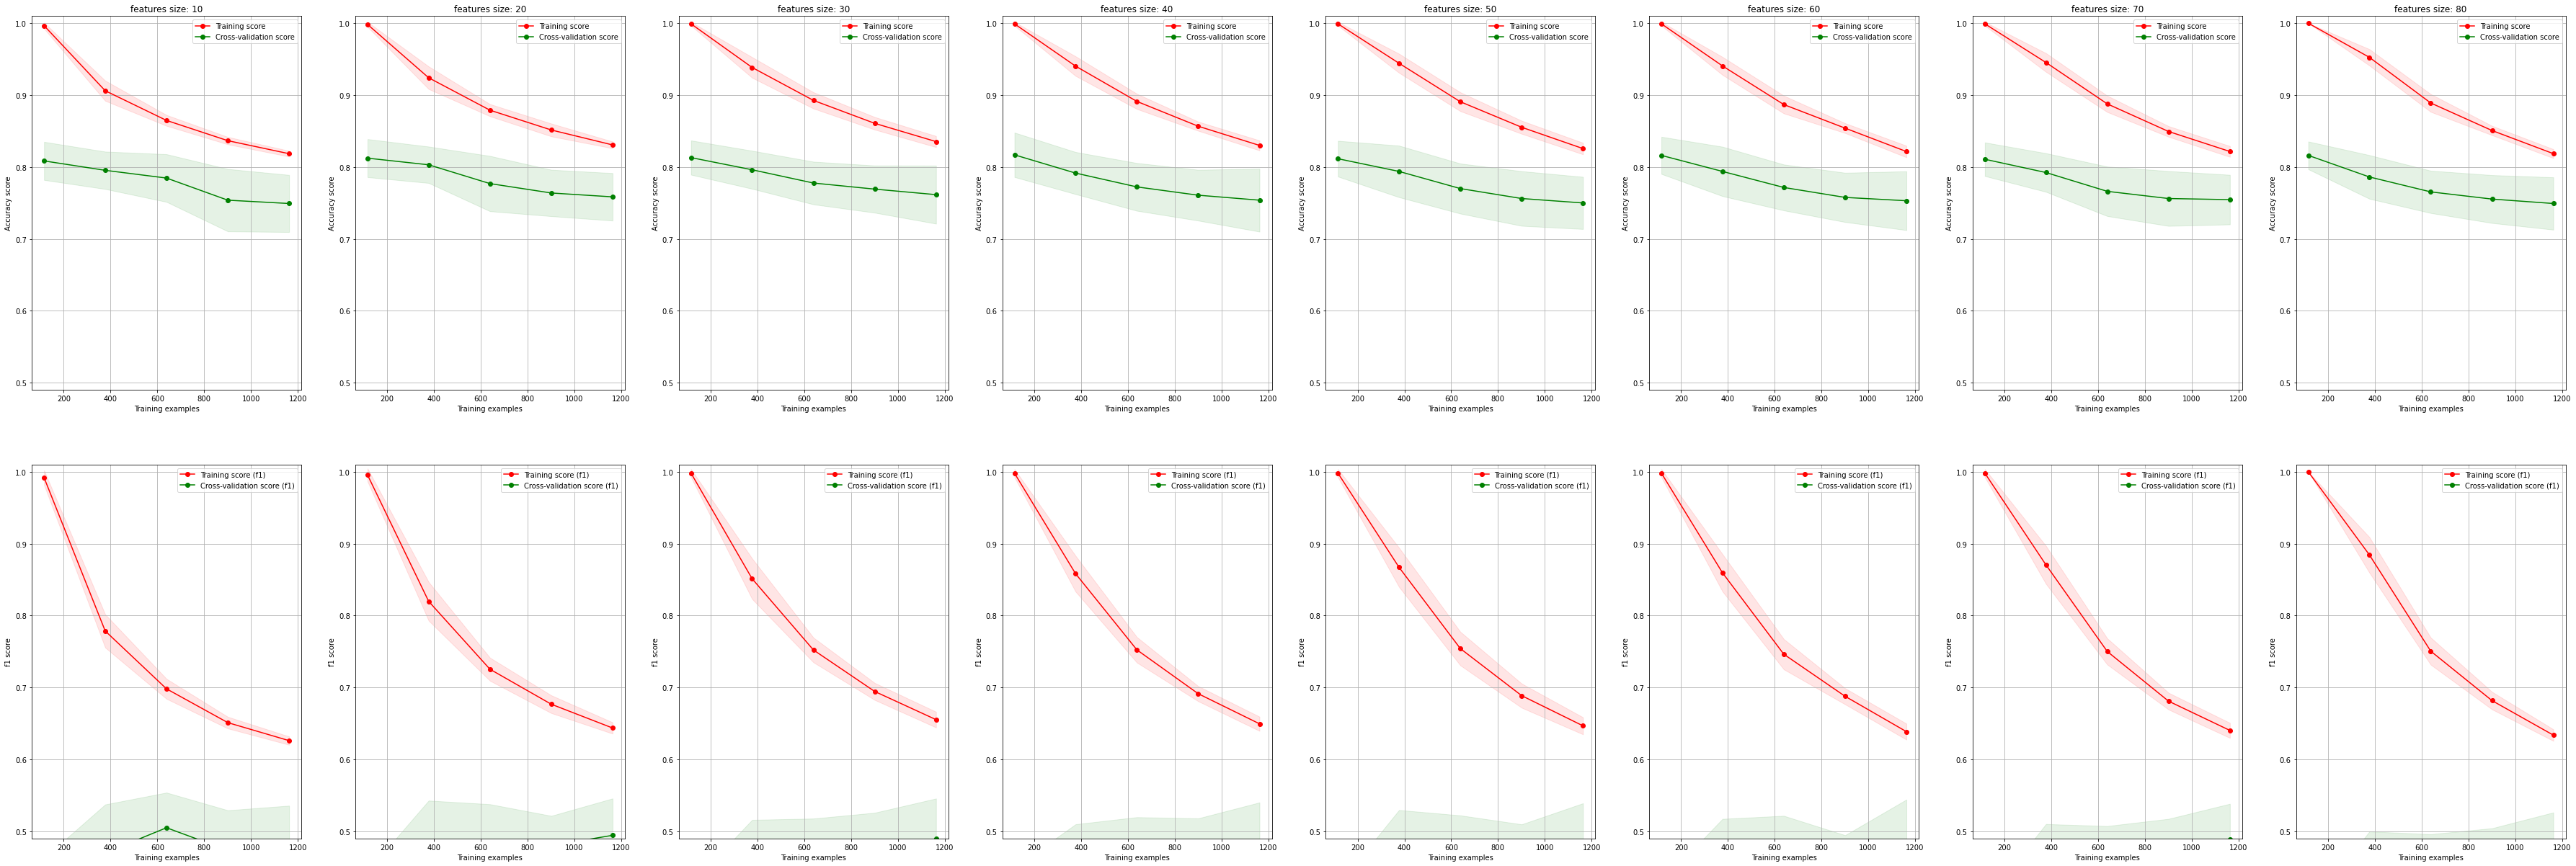

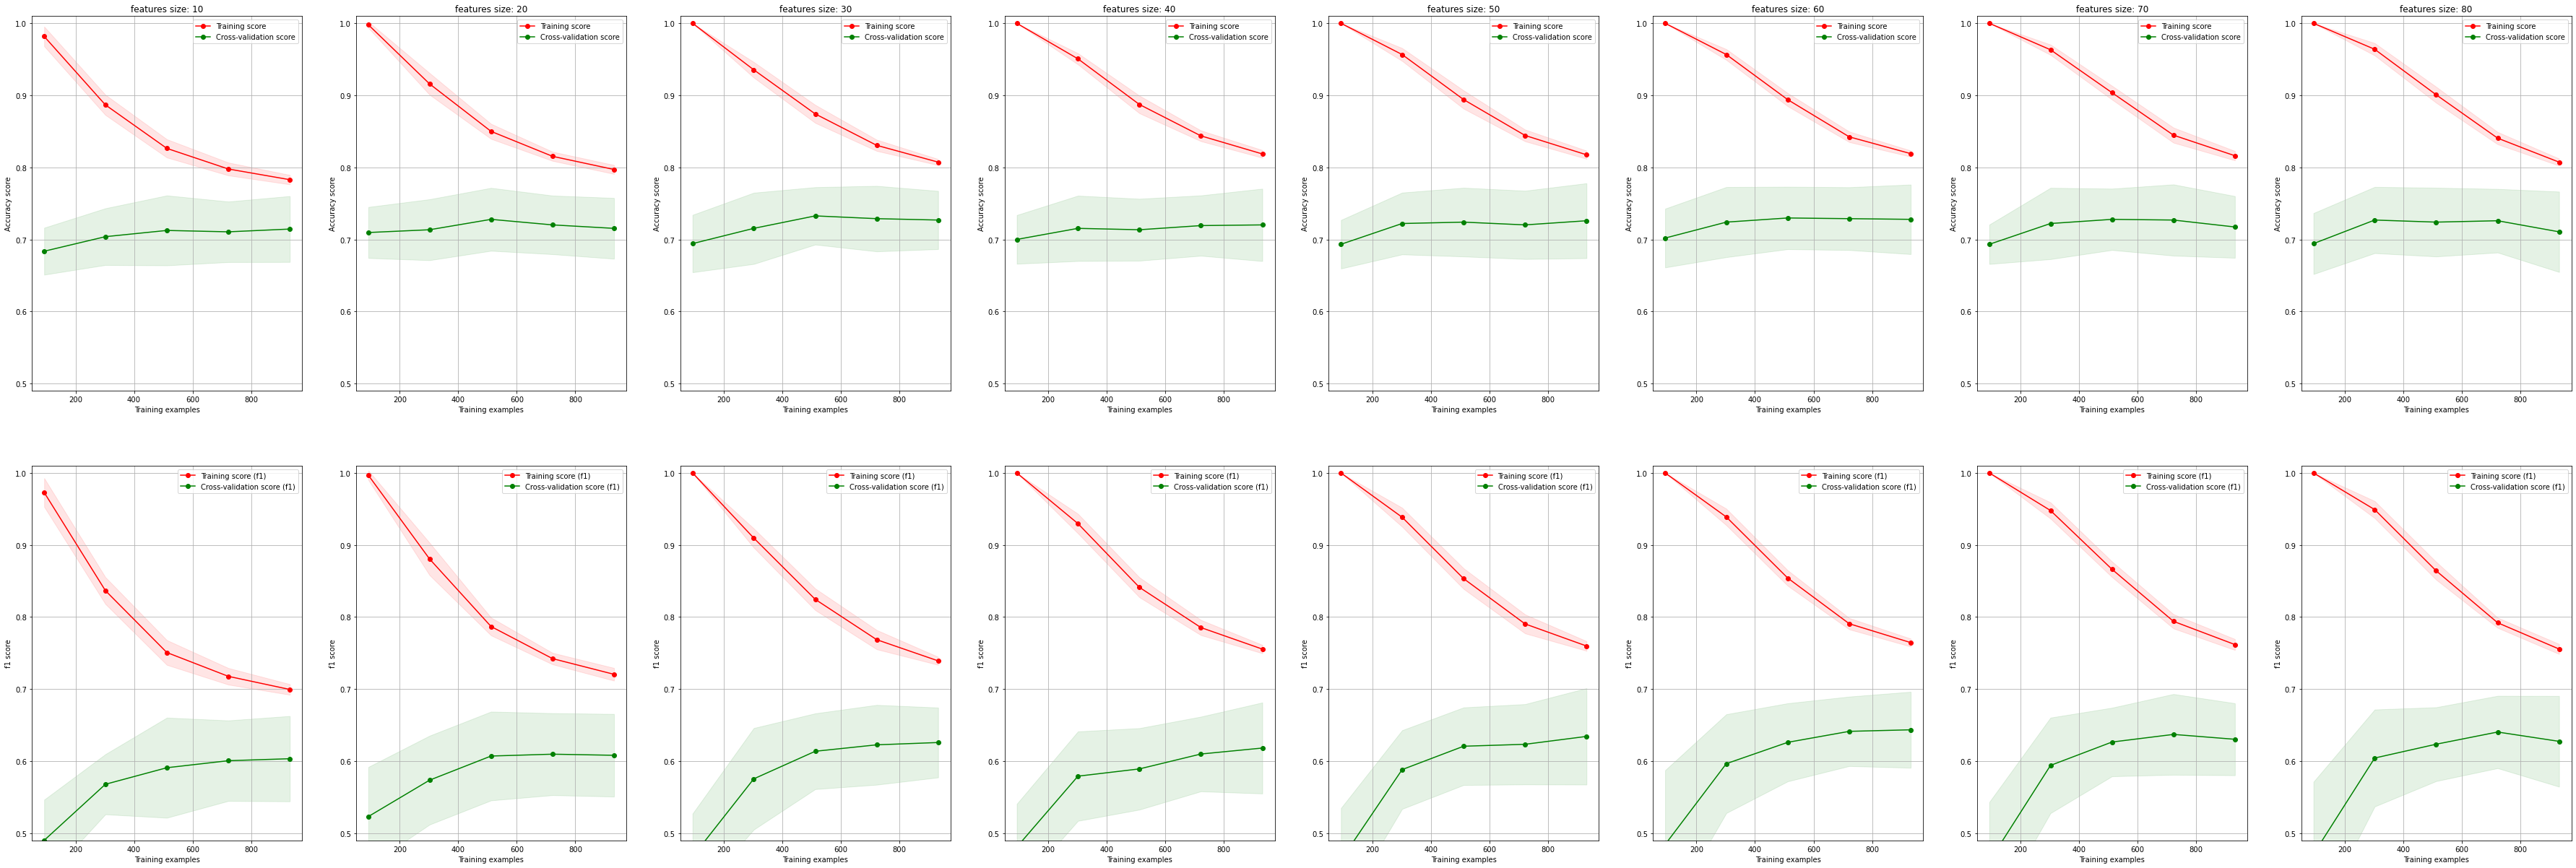

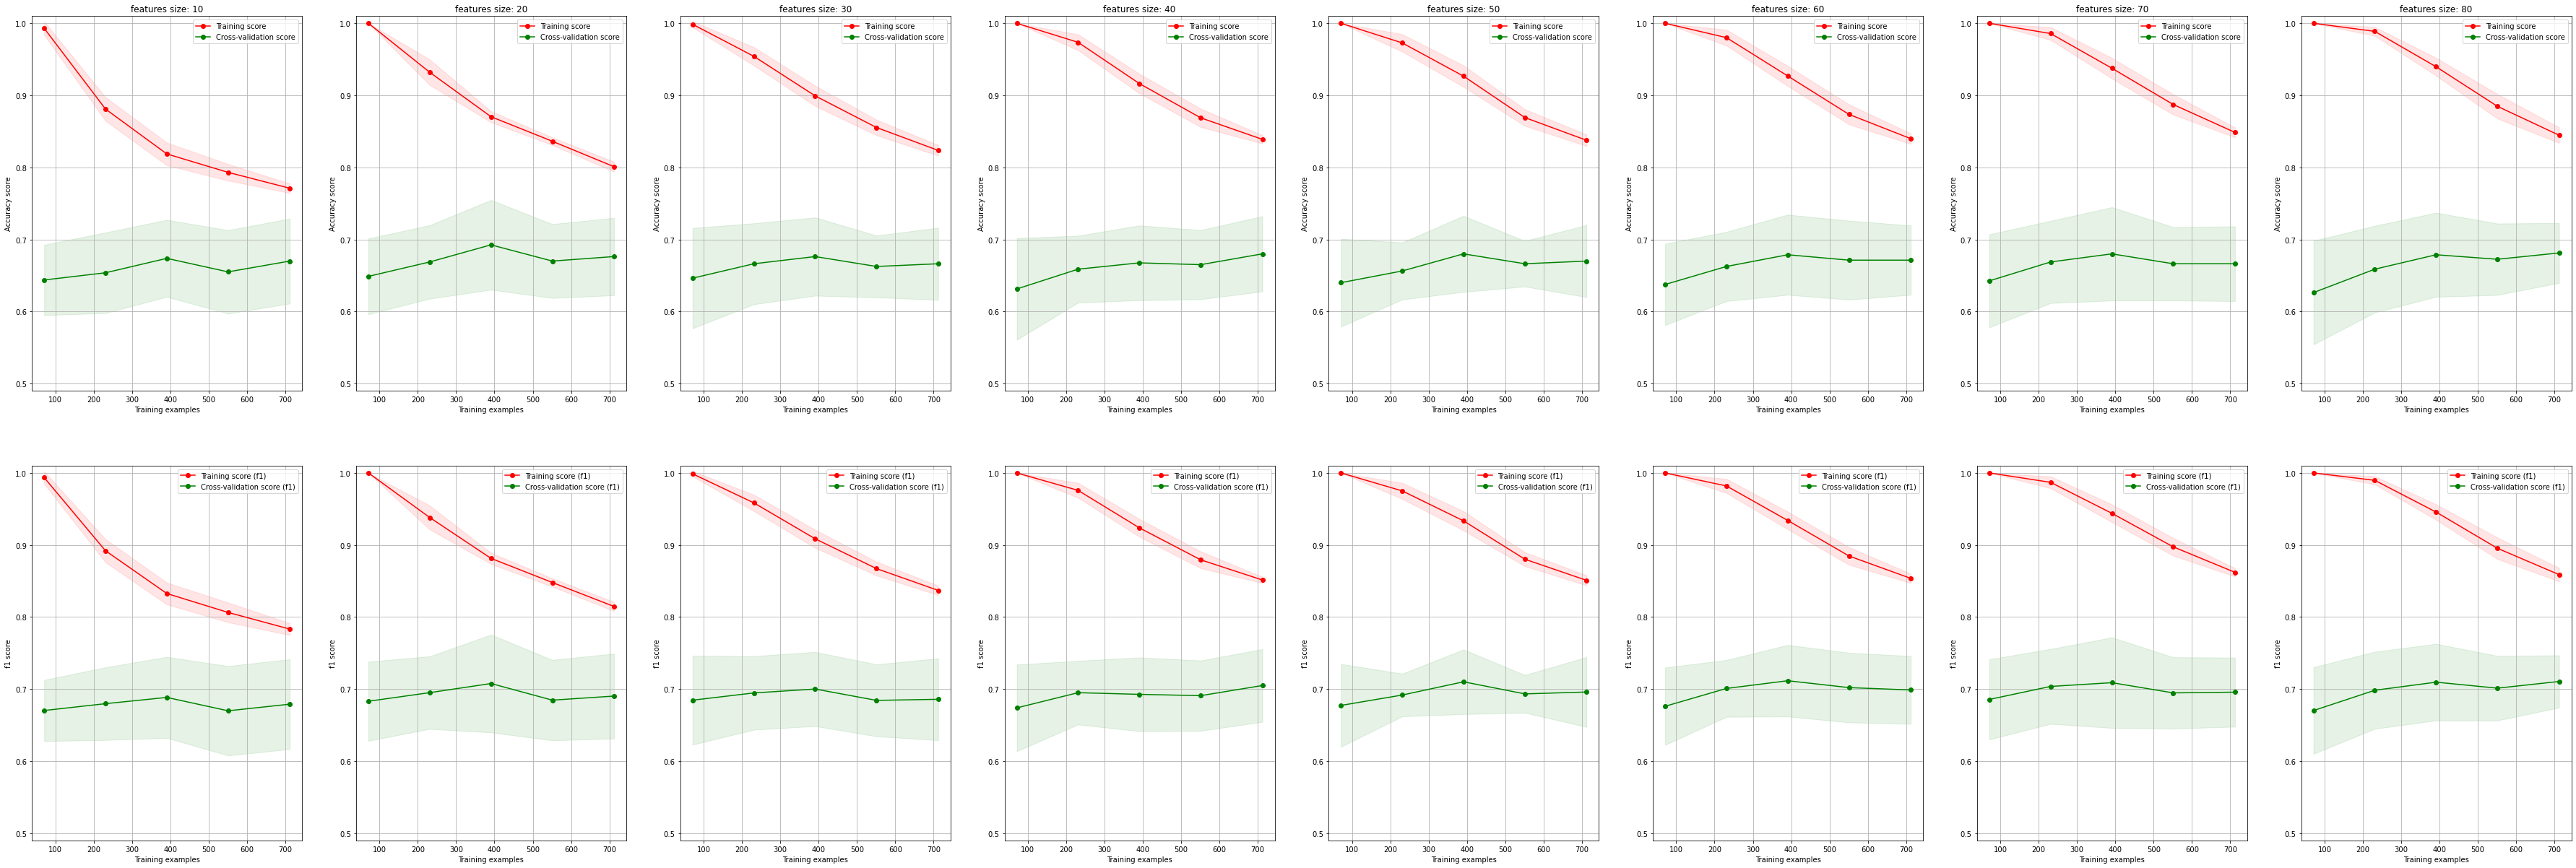

In [18]:
for year in tqdm(range(5, 16, 5)):  # 予後年数毎のループ
    # 特徴量選択から行うので特徴量選択前のデータから使用
    X = X_dict["basic"]["train"]["X{0:0=2}".format(year)]
    y = y_dict["basic"]["train"]["y{0:0=2}".format(year)]
    min_k = 10
    max_k = 80
    span = 10
    fig, axes = plt.subplots(2, (max_k - min_k) // span + 1, figsize=(63, 21))
    cv = StratifiedShuffleSplit(n_splits=10, random_state=SEED)

    for k in range(min_k, max_k + 1, span):
        # 特徴量選択するために、trainのデータを抽出
        X_train, _, y_train, _ = train_test_split(X, y, random_state=SEED, stratify=y)
        assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

        result_chi2 = feature_selection(X_train, y_train, chi2, "k_best", k)
        features = list(result_chi2[result_chi2["False: dropped"]].index)
        title = "features size: {0}".format(len(features))

        params = {
            "n_estimators": 500,
            "criterion": "entropy",
            "max_depth": 5,
            "max_leaf_nodes": 20,
            "max_features": "log2",
            "class_weight": "balanced",
            "random_state": SEED,
        }
        estimator = RandomForestClassifier(**params)

        # cvをplot_learning_curve内で実施するので、X(y)_trainは使用しない
        plot_learning_curve(
            estimator,
            title,
            X[features],
            y,
            axes=axes[:, k // span - 1],
            ylim=(0.49, 1.01),
            cv=cv,
            n_jobs=4,
            scoring="accuracy",
        )
    make_dir(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR + "/learning_curve/basic/chi2"
    )
    plt.savefig(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR
        + "/learning_curve/basic/chi2/X{0:0=2}.png".format(year)
    )

### mrmr

  0%|                                                                                   | 0/3 [00:00<?, ?it/s]

train_acc_mean:  [0.99913793 0.91299735 0.87261346 0.84528302 0.8288908 ]
test_acc_mean:  [0.80692308 0.79230769 0.77923077 0.76       0.76538462]
train_f1_mean:  [0.99818182 0.79829049 0.71648862 0.6659134  0.64261644]
test_f1_mean:  [0.33324319 0.46928442 0.48826697 0.47800129 0.50617197]
train_acc_mean:  [0.99913793 0.94350133 0.90375587 0.87047725 0.84840929]
test_acc_mean:  [0.82923077 0.79923077 0.78538462 0.76846154 0.77307692]
train_f1_mean:  [0.99818182 0.86404567 0.77465641 0.7106564  0.67418731]
test_f1_mean:  [0.34057818 0.44811471 0.48664395 0.47895341 0.50637573]
train_acc_mean:  [0.99913793 0.94960212 0.90688576 0.87591565 0.85313844]
test_acc_mean:  [0.82       0.80153846 0.78230769 0.77230769 0.76846154]
train_f1_mean:  [0.99818182 0.87652561 0.78169346 0.72057972 0.68286204]
test_f1_mean:  [0.30541082 0.45185107 0.47808561 0.48901178 0.50317462]
train_acc_mean:  [0.99913793 0.95331565 0.91032864 0.87314095 0.85004299]
test_acc_mean:  [0.82153846 0.80076923 0.78       

 33%|████████████████████████▋                                                 | 1/3 [08:36<17:12, 516.38s/it]

train_acc_mean:  [0.98817204 0.89966887 0.84804687 0.8166205  0.80085837]
test_acc_mean:  [0.71442308 0.69326923 0.7125     0.7125     0.70288462]
train_f1_mean:  [0.98266255 0.85393818 0.78118774 0.74358981 0.72434475]
test_f1_mean:  [0.54347648 0.55423253 0.58967167 0.60452934 0.59665823]
train_acc_mean:  [1.         0.94006623 0.88320312 0.85498615 0.83948498]
test_acc_mean:  [0.725      0.73461538 0.72692308 0.73269231 0.74038462]
train_f1_mean:  [1.         0.91337891 0.83372624 0.79760462 0.77967452]
test_f1_mean:  [0.53899891 0.60044612 0.6051004  0.62901439 0.64434435]
train_acc_mean:  [1.         0.94370861 0.88574219 0.85138504 0.82854077]
test_acc_mean:  [0.72403846 0.74423077 0.74326923 0.74134615 0.74903846]
train_f1_mean:  [1.         0.91993519 0.84015911 0.79782215 0.77238966]
test_f1_mean:  [0.53240281 0.62534066 0.63764295 0.64740199 0.66086892]
train_acc_mean:  [1.         0.95761589 0.90527344 0.86814404 0.84624464]
test_acc_mean:  [0.73461538 0.74615385 0.75576923 

 67%|█████████████████████████████████████████████████▎                        | 2/3 [16:51<08:23, 503.63s/it]

train_acc_mean:  [1.         0.91471861 0.86905371 0.83829401 0.80533708]
test_acc_mean:  [0.67625 0.68125 0.67875 0.68625 0.685  ]
train_f1_mean:  [1.         0.92146129 0.87776981 0.84548836 0.81168617]
test_f1_mean:  [0.70792683 0.70808085 0.69846123 0.70104531 0.70060257]
train_acc_mean:  [1.         0.94675325 0.90460358 0.86787659 0.84424157]
test_acc_mean:  [0.6925  0.71125 0.71375 0.715   0.71875]
train_f1_mean:  [1.         0.95077879 0.91111164 0.87497214 0.85144457]
test_f1_mean:  [0.71899052 0.7359715  0.73389328 0.73553575 0.73704792]
train_acc_mean:  [1.         0.95584416 0.91150895 0.88330309 0.85337079]
test_acc_mean:  [0.69625 0.71    0.70875 0.7175  0.71625]
train_f1_mean:  [1.         0.95917405 0.91764201 0.88920241 0.86065003]
test_f1_mean:  [0.73025038 0.73415966 0.73226204 0.74120654 0.73846828]
train_acc_mean:  [1.         0.97229437 0.9258312  0.8907441  0.86544944]
test_acc_mean:  [0.6975  0.70375 0.6975  0.68875 0.7075 ]
train_f1_mean:  [1.         0.9743714

100%|██████████████████████████████████████████████████████████████████████████| 3/3 [24:44<00:00, 494.80s/it]


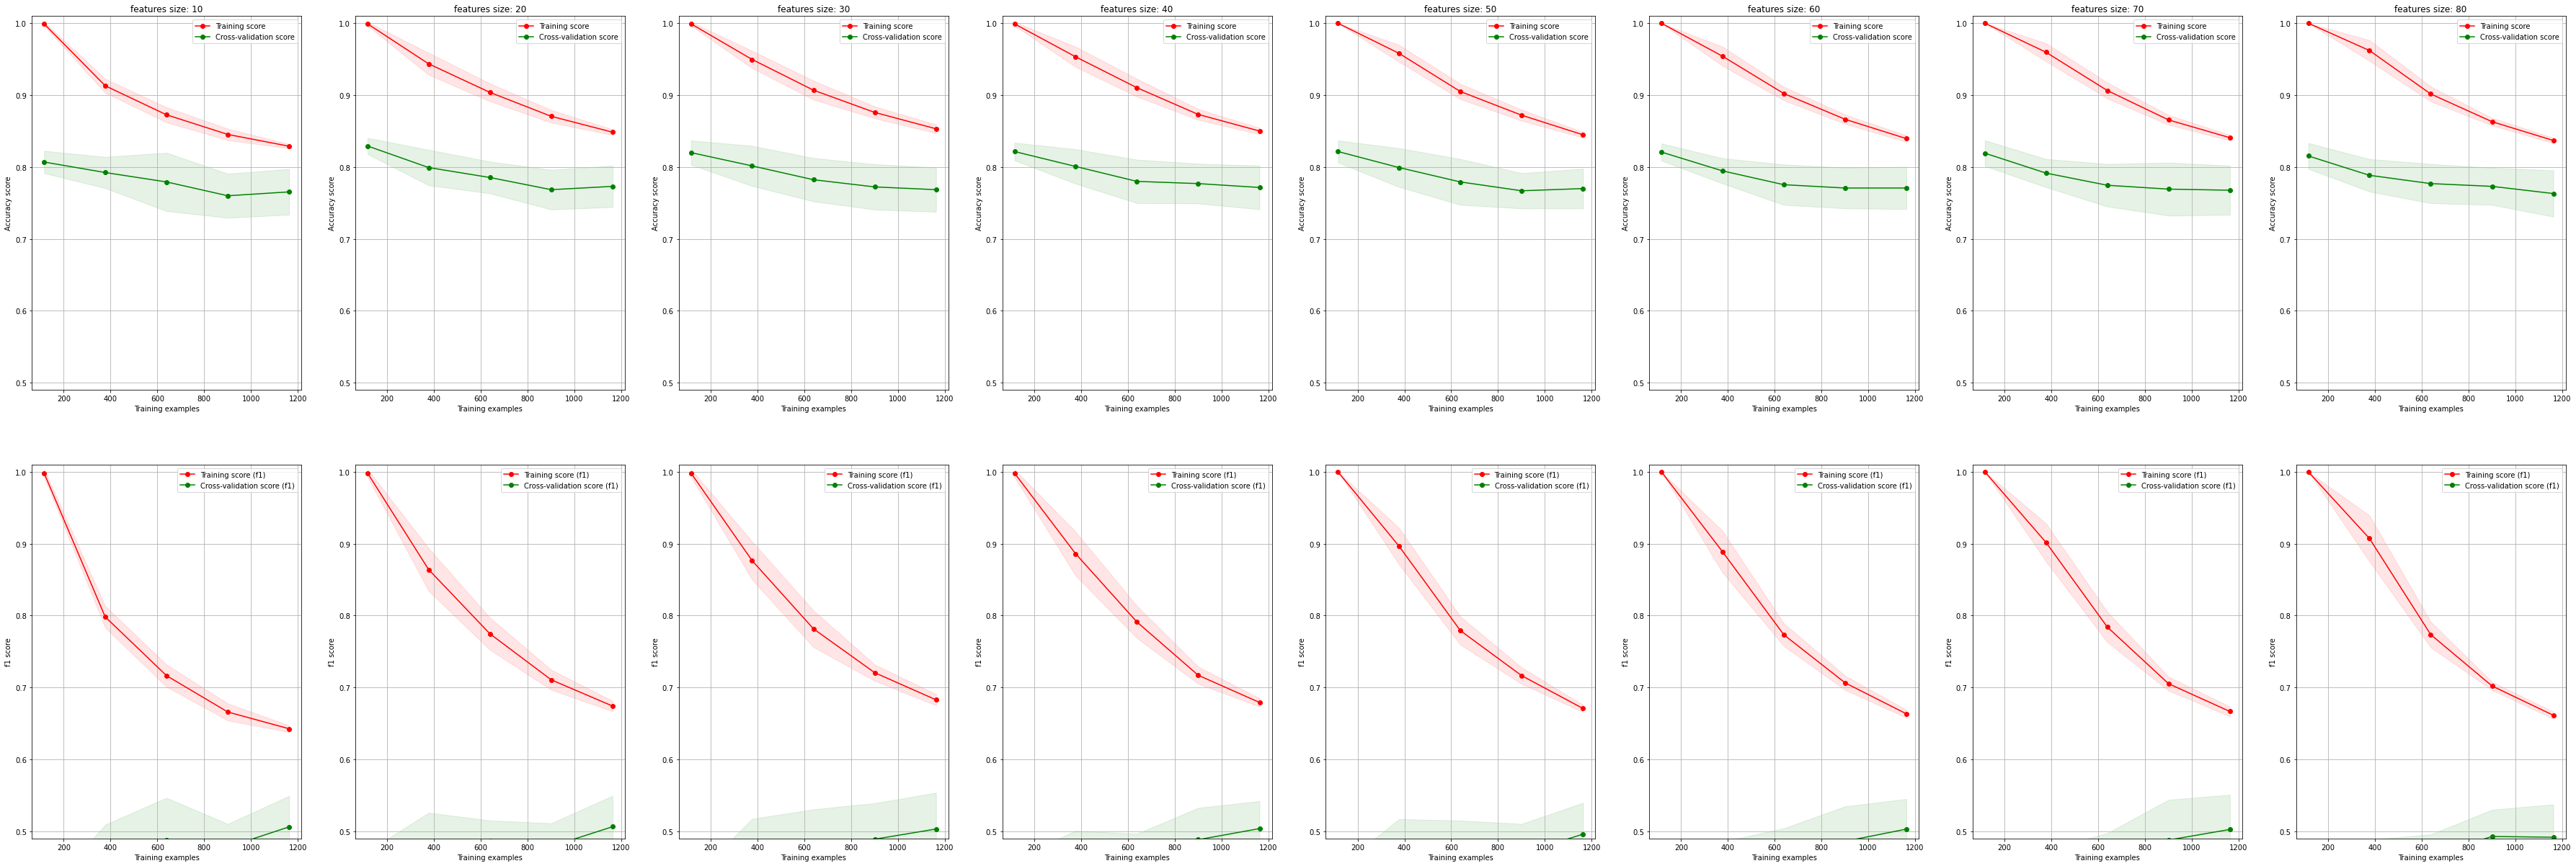

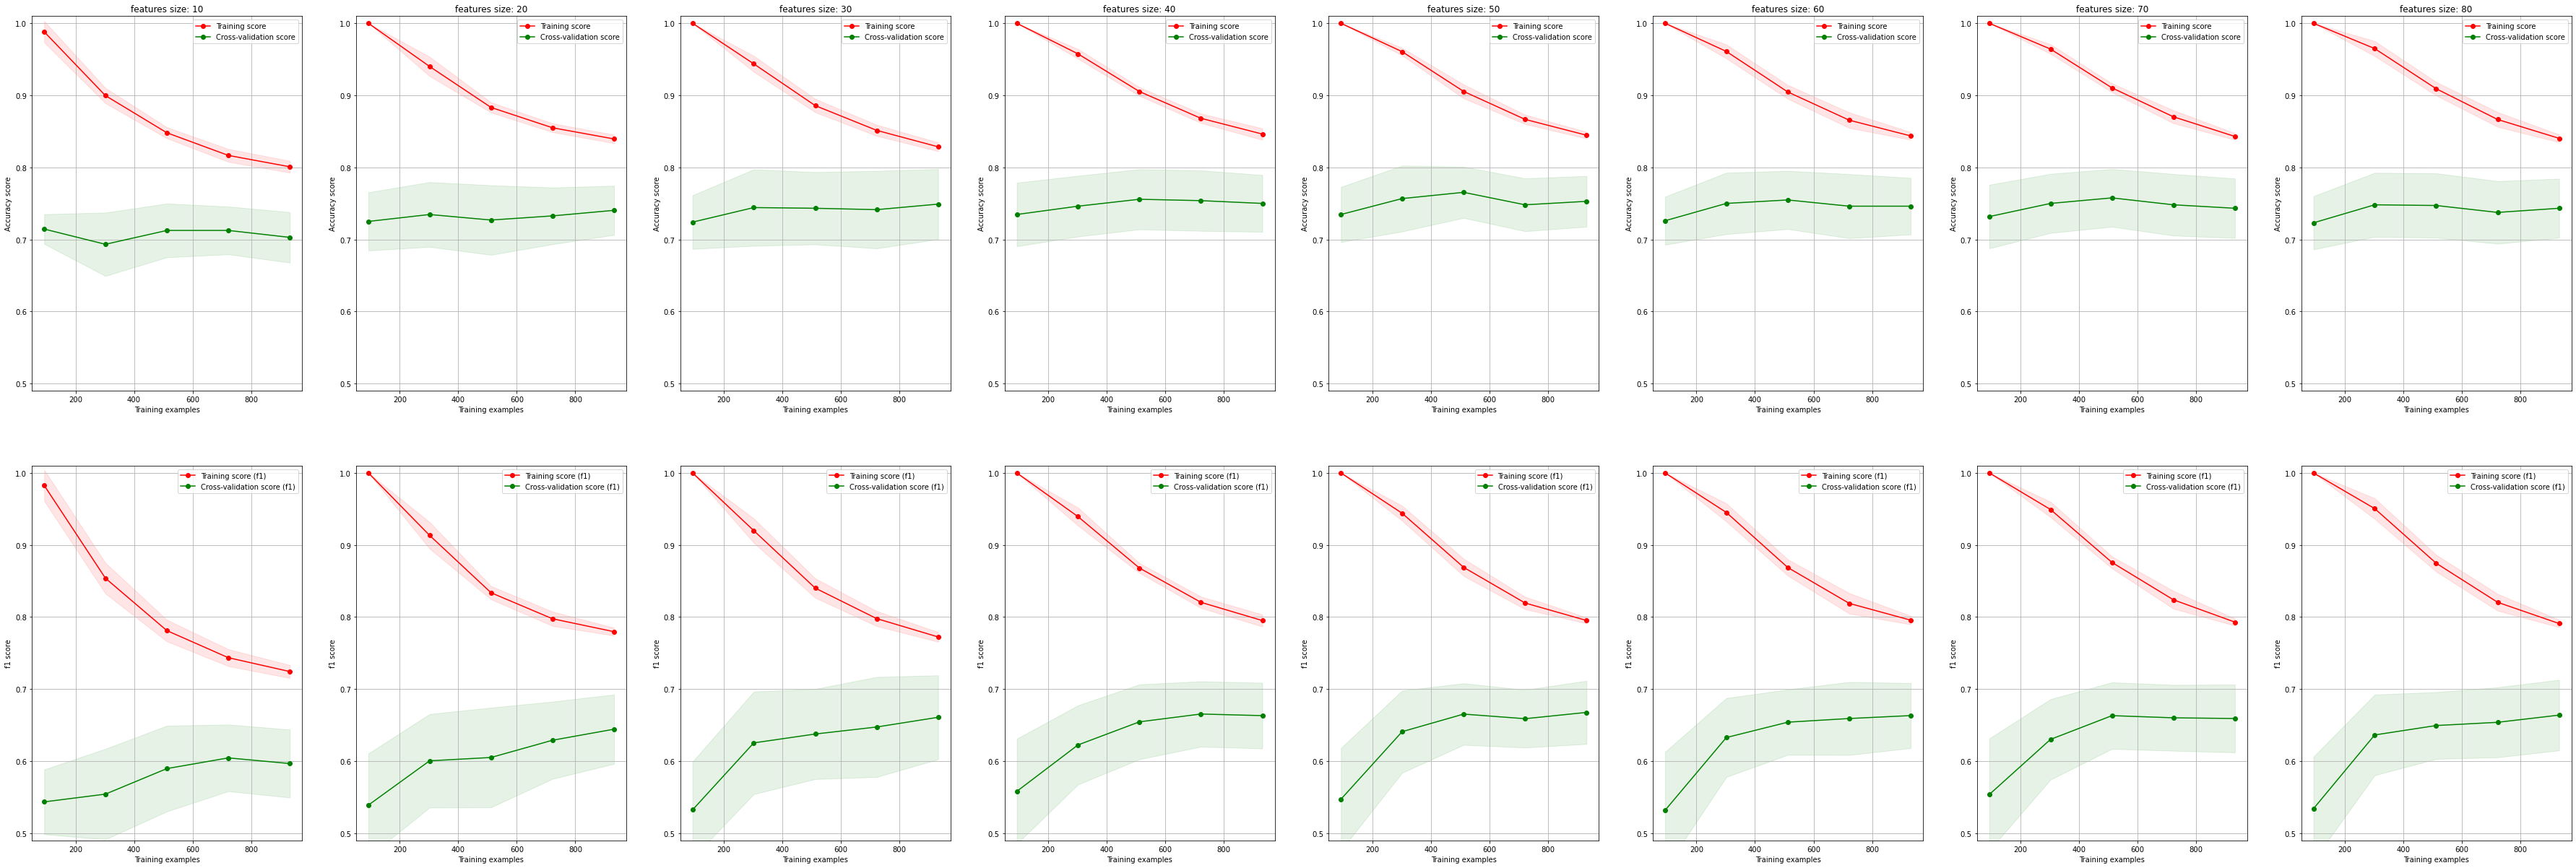

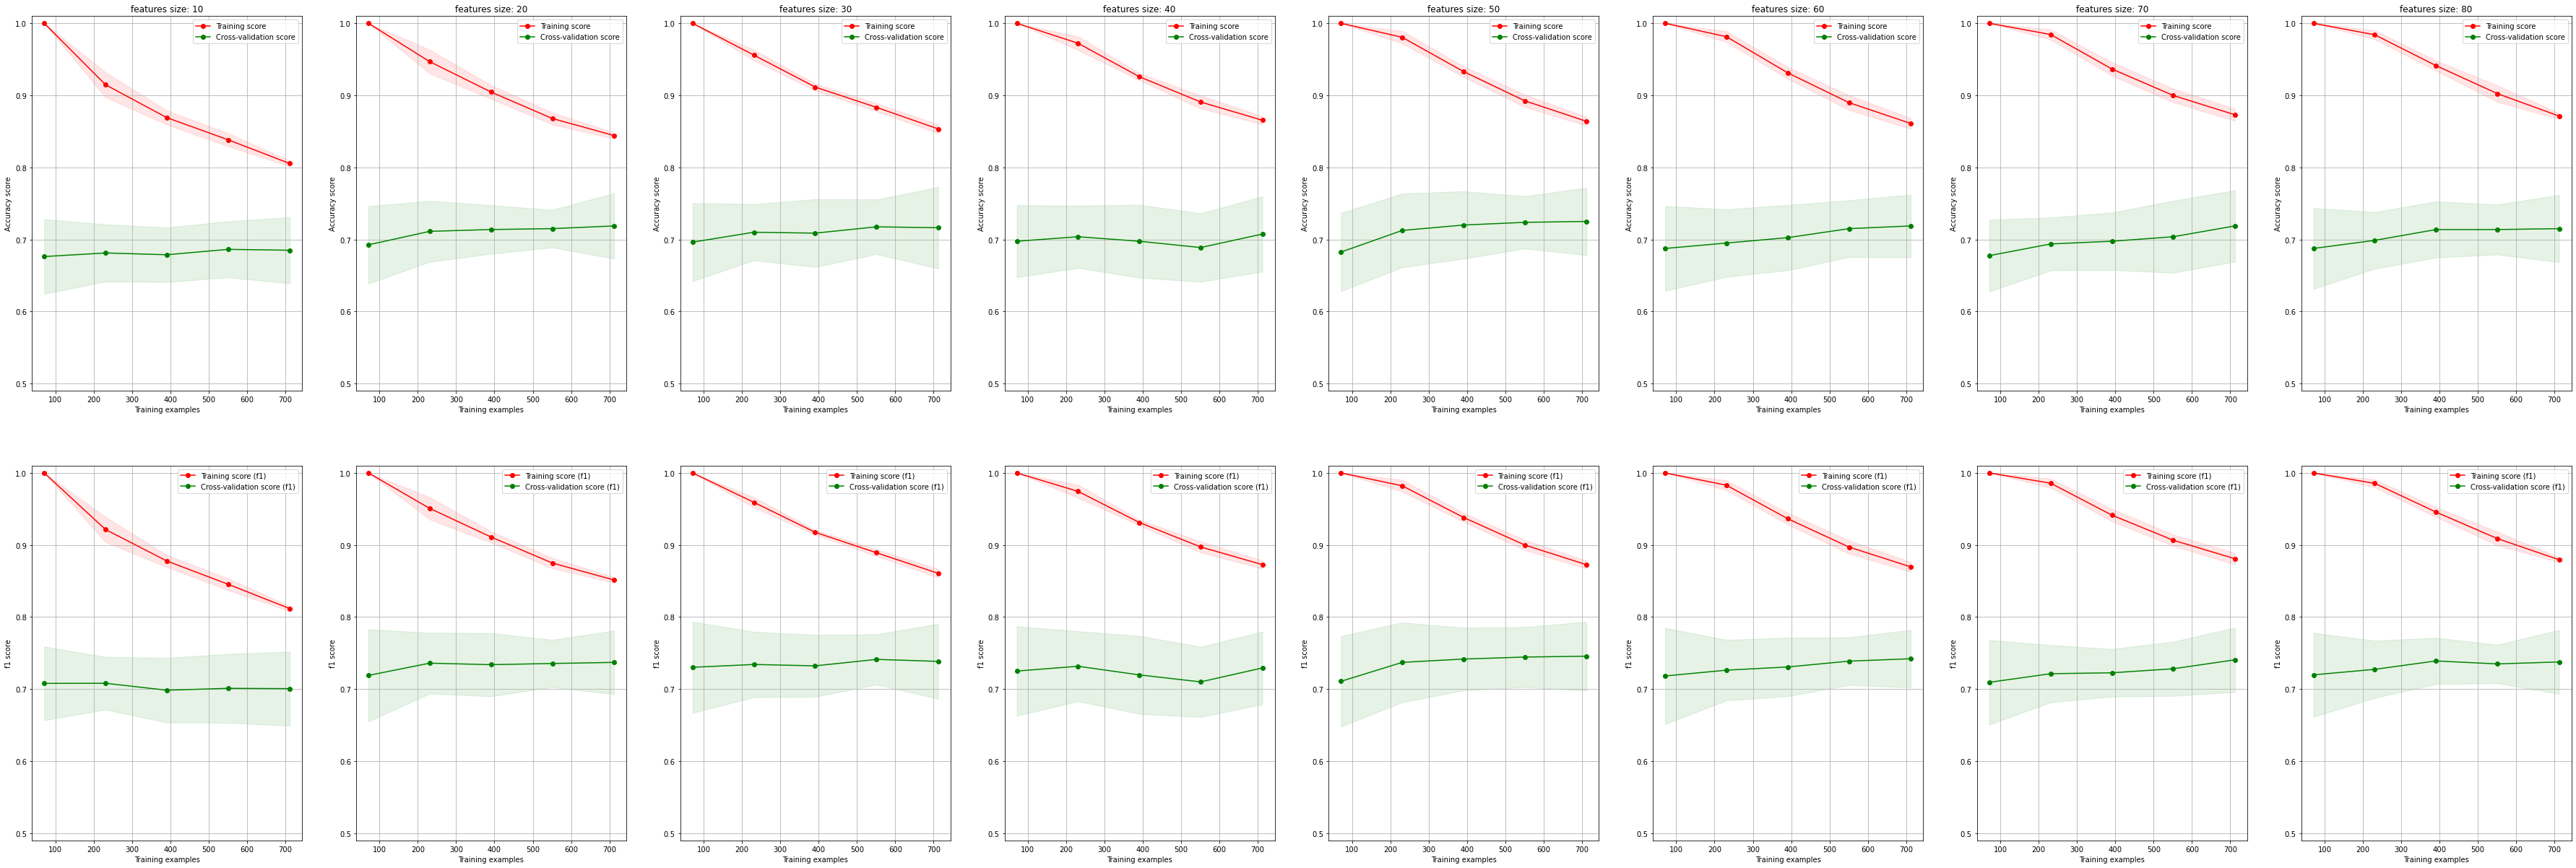

In [19]:
for year in tqdm(range(5, 16, 5)):  # 予後年数毎のループ
    # 特徴量選択から行うので特徴量選択前のデータから使用
    X = X_dict["basic"]["train"]["X{0:0=2}".format(year)]
    y = y_dict["basic"]["train"]["y{0:0=2}".format(year)]
    min_k = 10
    max_k = 80
    span = 10
    fig, axes = plt.subplots(2, (max_k - min_k) // span + 1, figsize=(63, 21))
    cv = StratifiedShuffleSplit(n_splits=10, random_state=SEED)

    for k in range(min_k, max_k + 1, span):
        # 特徴量選択するために、trainのデータを抽出
        X_train, _, y_train, _ = train_test_split(X, y, random_state=SEED, stratify=y)
        assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

        features = mrmr.mrmr_classif(
            X=X_train,
            y=y_train,
            K=k,
            show_progress=False,
        )
        title = "features size: {0}".format(len(features))

        params = {
            "n_estimators": 500,
            "criterion": "entropy",
            "max_depth": 5,
            "max_leaf_nodes": 20,
            "max_features": "log2",
            "class_weight": "balanced",
            "random_state": SEED,
        }
        estimator = RandomForestClassifier(**params)

        # cvをplot_learning_curve内で実施するので、X(y)_trainは使用しない
        plot_learning_curve(
            estimator,
            title,
            X[features],
            y,
            axes=axes[:, (k-min_k ) // span],
            ylim=(0.49, 1.01),
            cv=cv,
            n_jobs=4,
            scoring="accuracy",
        )
    make_dir(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR + "/learning_curve/basic/mrmr"
    )
    plt.savefig(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR
        + "/learning_curve/basic/mrmr/X{0:0=2}.png".format(year)
    )

### boruta

  0%|                                                                                   | 0/3 [00:00<?, ?it/s]

year: 5
--------------------------------------------------
k num:  10
62
train_acc_mean:  [0.99655172 0.92148541 0.8657277  0.83618202 0.81564918]
test_acc_mean:  [0.81461538 0.78307692 0.77769231 0.76230769 0.76307692]
train_f1_mean:  [0.992141   0.81145416 0.70095575 0.6510372  0.61962461]
test_f1_mean:  [0.35025123 0.43686462 0.4889361  0.49421792 0.50688913]
--------------------------------------------------
k num:  20
62
train_acc_mean:  [1.         0.9397878  0.89123631 0.85704772 0.83903697]
test_acc_mean:  [0.82153846 0.79615385 0.78538462 0.77538462 0.77384615]
train_f1_mean:  [1.         0.85412832 0.75011926 0.68604286 0.65439004]
test_f1_mean:  [0.37515317 0.46392117 0.49637067 0.50491155 0.51336016]
--------------------------------------------------
k num:  30
62
train_acc_mean:  [1.         0.94774536 0.88967136 0.85604883 0.83061049]
test_acc_mean:  [0.81538462 0.79846154 0.77692308 0.76846154 0.75461538]
train_f1_mean:  [1.         0.87156848 0.74779707 0.68696575 0.648

 33%|████████████████████████▎                                                | 1/3 [27:11<54:23, 1631.75s/it]

year: 10
--------------------------------------------------
k num:  10
35
train_acc_mean:  [0.98924731 0.88807947 0.82851562 0.79639889 0.78251073]
test_acc_mean:  [0.70192308 0.71057692 0.725      0.725      0.71923077]
train_f1_mean:  [0.98417046 0.8446521  0.76039246 0.72135595 0.70612875]
test_f1_mean:  [0.5464249  0.58326668 0.60973838 0.61935239 0.61493481]
--------------------------------------------------
k num:  20
35
train_acc_mean:  [0.99892473 0.92582781 0.85957031 0.82576177 0.80793991]
test_acc_mean:  [0.72019231 0.73173077 0.73653846 0.73076923 0.73076923]
train_f1_mean:  [0.99863014 0.89688663 0.80880628 0.76825199 0.74839921]
test_f1_mean:  [0.55721463 0.60538052 0.62921345 0.63244381 0.63618782]
--------------------------------------------------
k num:  30
35
train_acc_mean:  [1.         0.94437086 0.87714844 0.83476454 0.81201717]
test_acc_mean:  [0.725      0.73557692 0.74519231 0.74134615 0.7375    ]
train_f1_mean:  [1.         0.92177765 0.83230125 0.78056722 0.75

 67%|████████████████████████████████████████████████▋                        | 2/3 [49:51<24:31, 1471.93s/it]

year: 15
--------------------------------------------------
k num:  10
45
train_acc_mean:  [0.9971831  0.91038961 0.85140665 0.82032668 0.8       ]
test_acc_mean:  [0.66125 0.69375 0.68375 0.695   0.68875]
train_f1_mean:  [0.99756098 0.91716189 0.86100107 0.83001813 0.80869124]
test_f1_mean:  [0.69224876 0.71352108 0.69733072 0.7071364  0.7020959 ]
--------------------------------------------------
k num:  20
45
train_acc_mean:  [1.         0.94025974 0.89693095 0.86297641 0.84648876]
test_acc_mean:  [0.68125 0.6825  0.7025  0.6925  0.69625]
train_f1_mean:  [1.         0.94461829 0.90433603 0.87120813 0.8540953 ]
test_f1_mean:  [0.70818503 0.70613192 0.72220804 0.71534174 0.71390373]
--------------------------------------------------
k num:  30
45
train_acc_mean:  [1.         0.96103896 0.91355499 0.8800363  0.85617978]
test_acc_mean:  [0.675   0.69    0.705   0.715   0.71375]
train_f1_mean:  [1.         0.96412227 0.91998582 0.88726337 0.8638713 ]
test_f1_mean:  [0.70196559 0.71374379

100%|███████████████████████████████████████████████████████████████████████| 3/3 [1:13:57<00:00, 1479.09s/it]


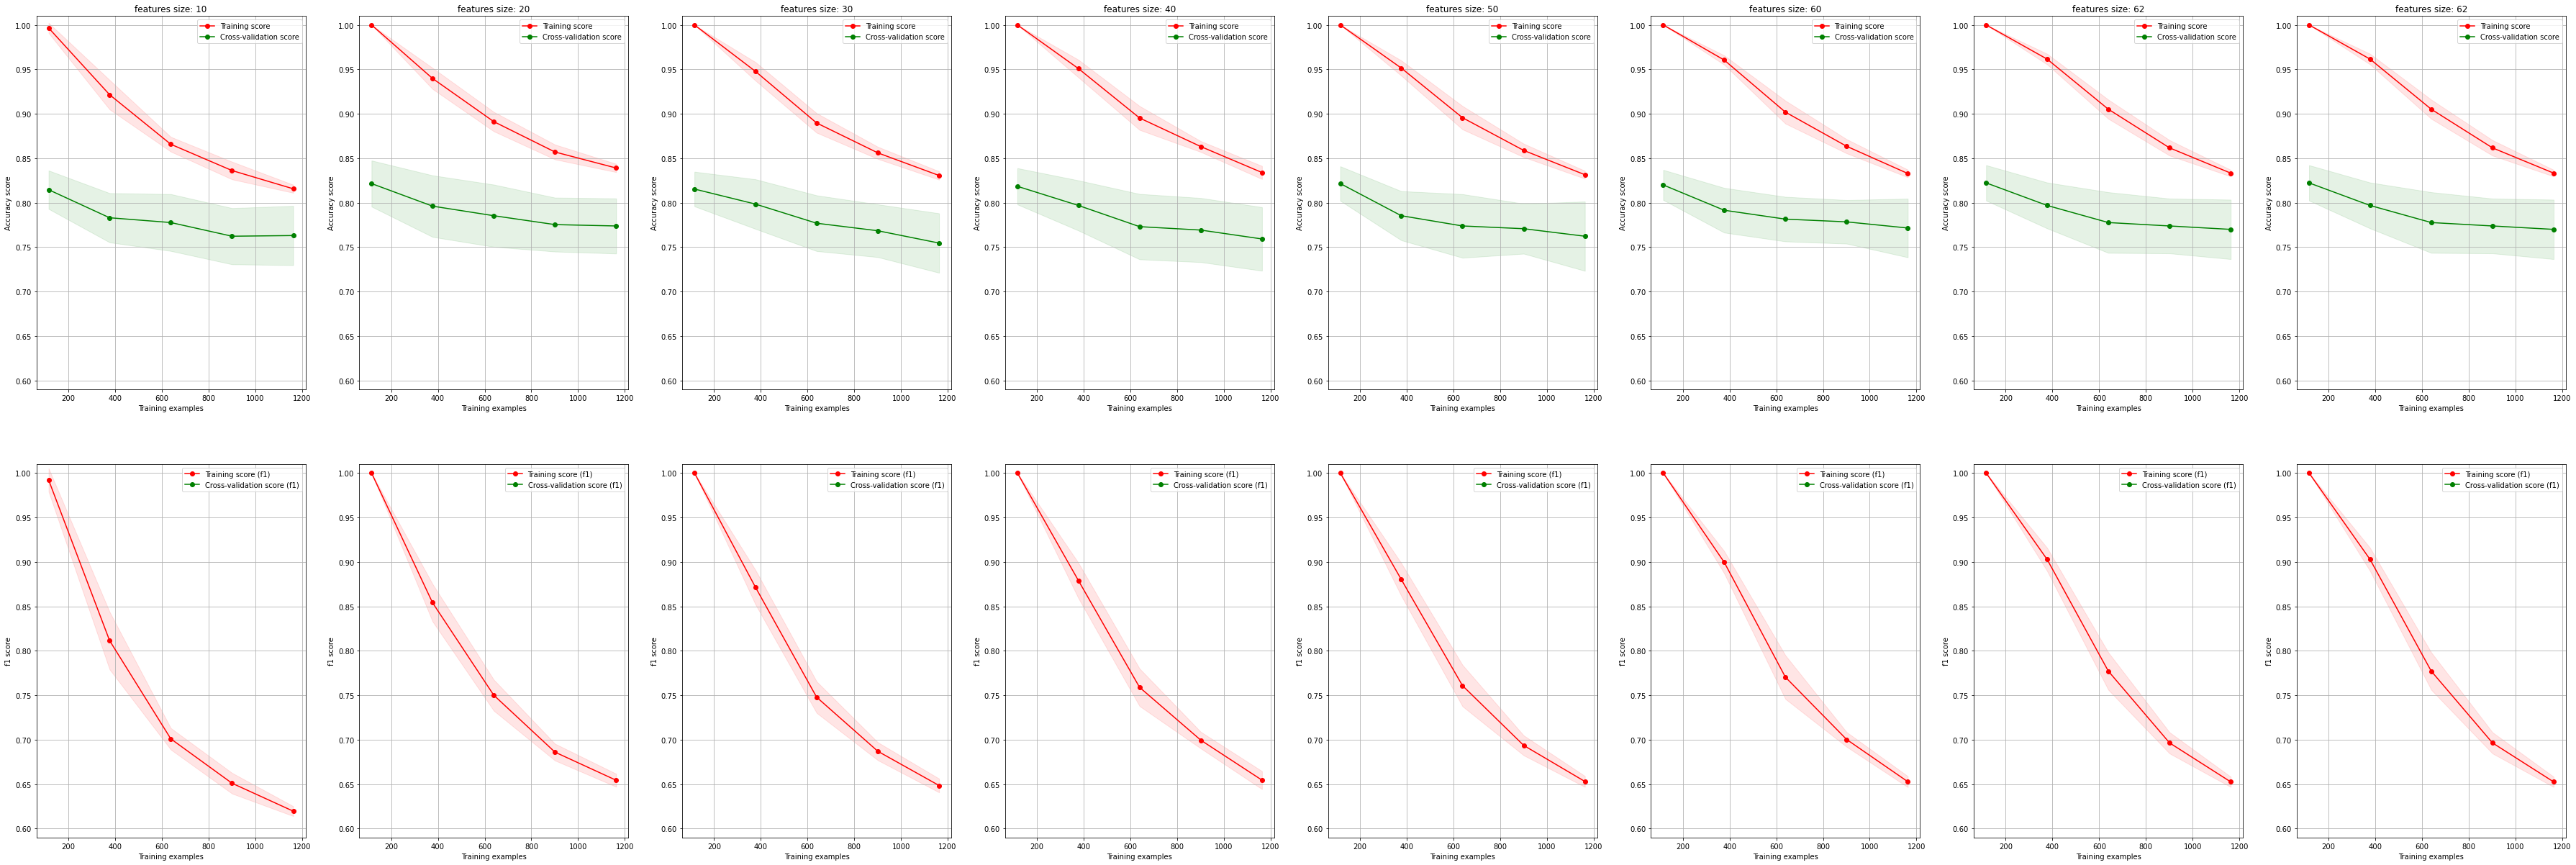

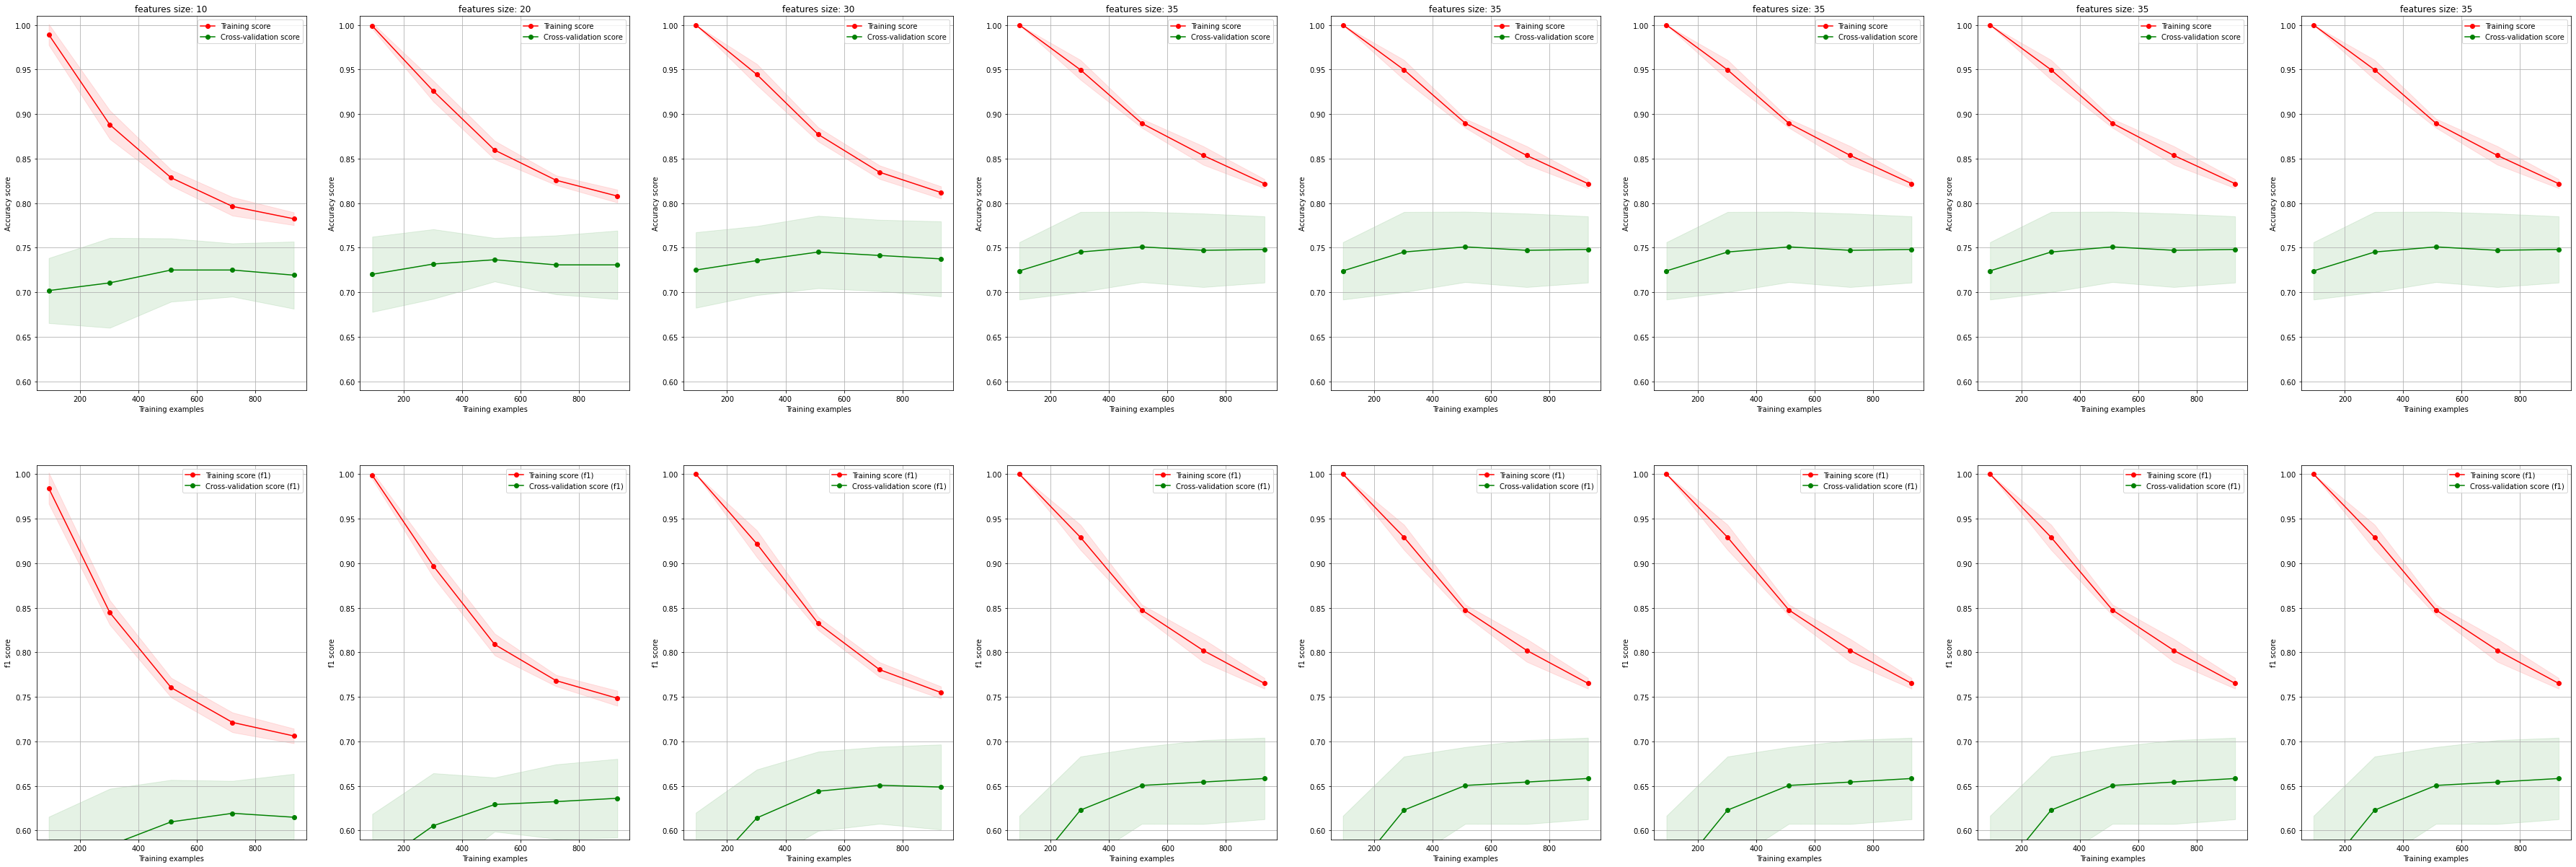

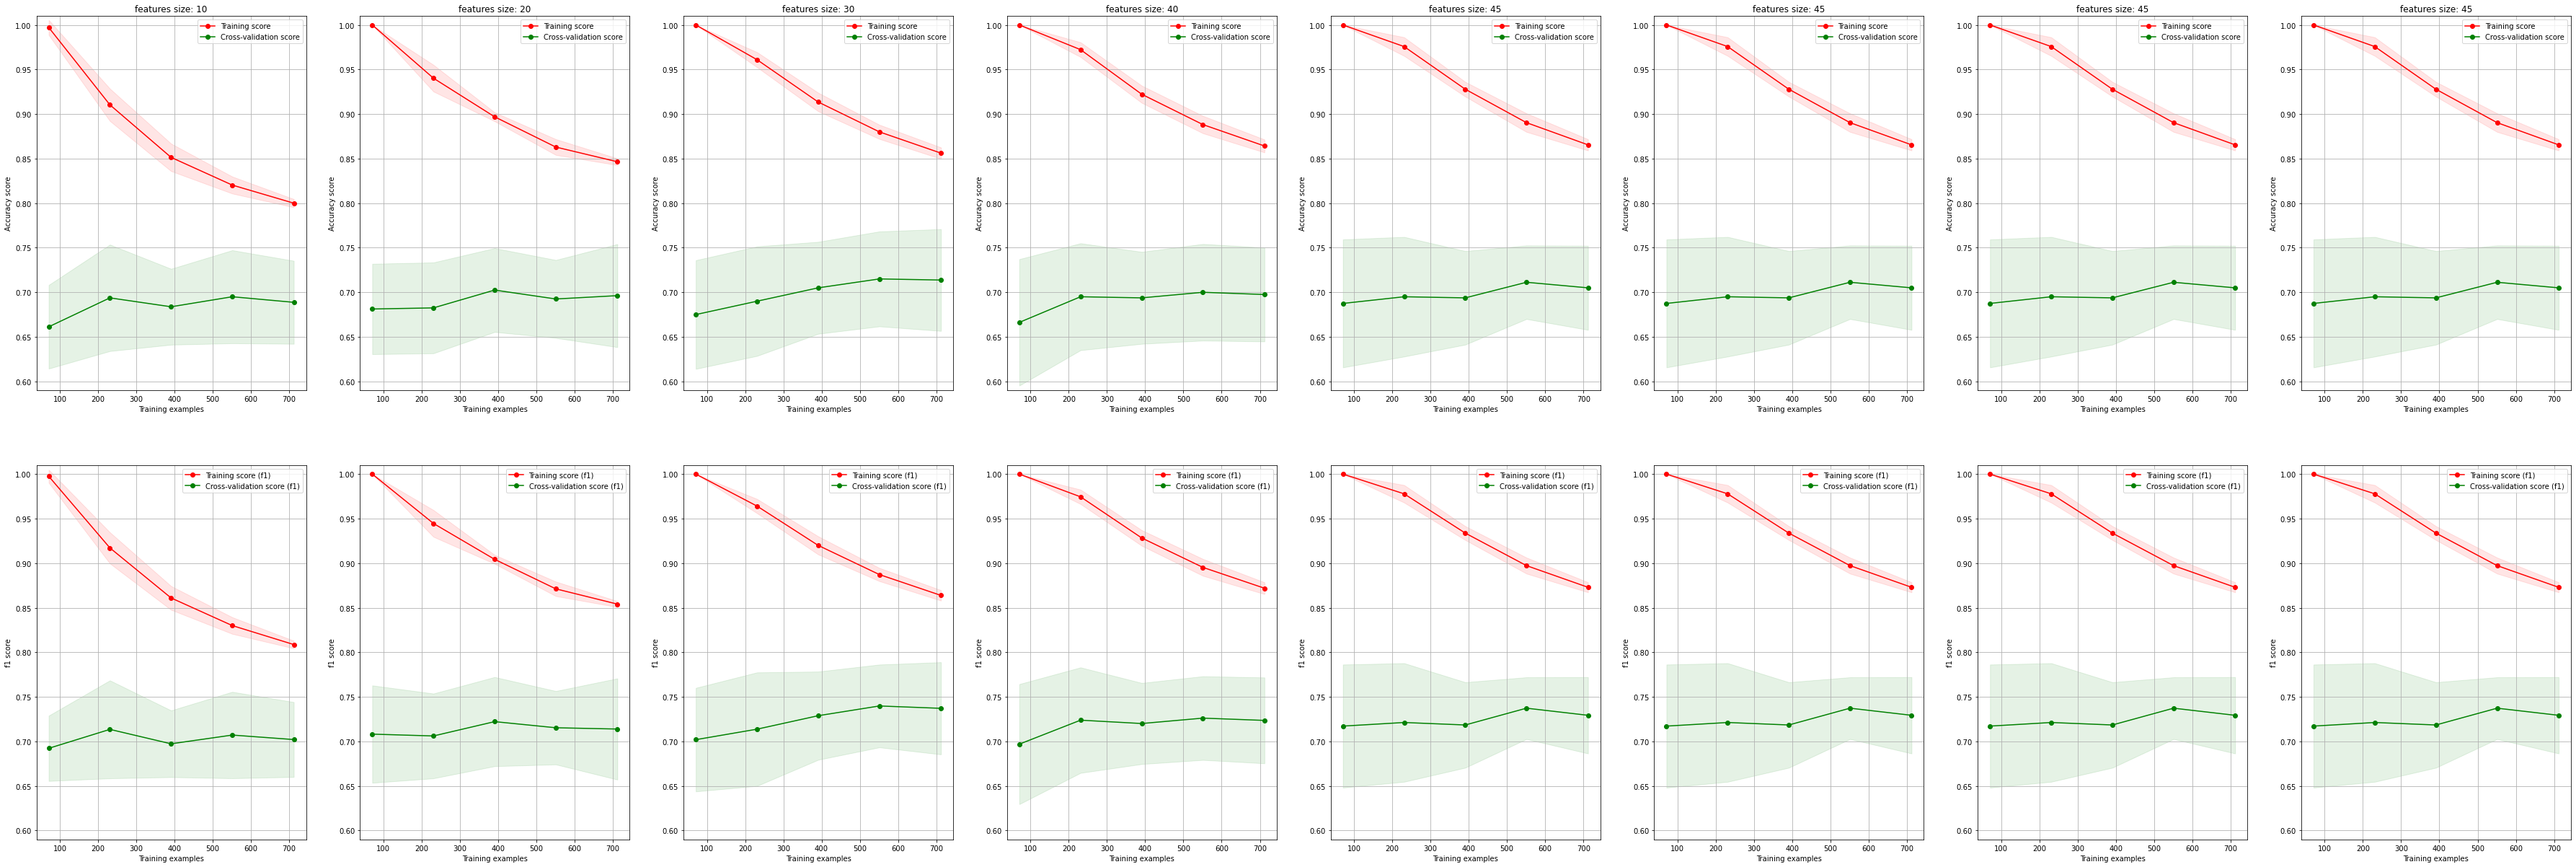

In [28]:
warnings.simplefilter('ignore')

for year in tqdm(range(5, 16, 5)):  # 予後年数毎のループ
    # 特徴量選択から行うので特徴量選択前のデータから使用
    X = X_dict["basic"]["train"]["X{0:0=2}".format(year)]
    y = y_dict["basic"]["train"]["y{0:0=2}".format(year)]
    min_k = 10
    max_k = 80
    span = 10
    fig, axes = plt.subplots(2, (max_k - min_k) // span + 1, figsize=(63, 21))
    cv = StratifiedShuffleSplit(n_splits=10, random_state=SEED)
    print('year:',year)

    for k in range(min_k, max_k + 1, span):
        print('-----'*10)
        print('k num: ',k)
        # 特徴量選択するために、trainのデータを抽出
        X_train, _, y_train, _ = train_test_split(X, y, random_state=SEED, stratify=y)
        assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

        # RandomForestClassifierでBorutaを実行
        rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=SEED)
        feat_selector = BorutaPy(rf, n_estimators="auto", verbose=0, random_state=SEED)
        feat_selector.fit(
            X_train.values,
            y_train.values,
        )
        # 選択された特徴量を確認
        print(len(X_train.columns[feat_selector.support_]))
        features = X_train.columns[feat_selector.support_][:k]

        title = "features size: {0}".format(len(features))

        params = {
            "n_estimators": 500,
            "criterion": "entropy",
            "max_depth": 5,
            "max_leaf_nodes": 20,
            "max_features": "log2",
            "class_weight": "balanced",
            "random_state": SEED,
        }
        estimator = RandomForestClassifier(**params)

        # cvをplot_learning_curve内で実施するので、X(y)_trainは使用しない
        plot_learning_curve(
            estimator,
            title,
            X[features],
            y,
            axes=axes[:, k // span - 1],
            ylim=(0.59, 1.01),
            cv=cv,
            n_jobs=4,
            scoring="accuracy",
        )
    make_dir(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR + "/learning_curve/basic/boruta"
    )
    plt.savefig(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR
        + "/learning_curve/basic/boruta/X{0:0=2}.png".format(year)
    )

## 詳細な絞り込み

学習曲線上ではtarinとtestの差がデータ数を増やしても劇的に減るわけではなかった  
→データ数を増やすのはあまり効果がない？

mrmrは20付近がf1が高く、かつ特徴量数が少なくて済んでいる

特徴量選択時のリークをなくし、精度を見ていく

  0%|                                                                                   | 0/1 [00:00<?, ?it/s]

year: 15
--------------------------------------------------
k num:  10
train_acc_mean:  [1.         0.91471861 0.86905371 0.83829401 0.80533708]
test_acc_mean:  [0.67625 0.68125 0.67875 0.68625 0.685  ]
train_f1_mean:  [1.         0.92146129 0.87776981 0.84548836 0.81168617]
test_f1_mean:  [0.70792683 0.70808085 0.69846123 0.70104531 0.70060257]
--------------------------------------------------
k num:  11
train_acc_mean:  [1.         0.91818182 0.87084399 0.8353902  0.80688202]
test_acc_mean:  [0.66375 0.6775  0.6925  0.68    0.6775 ]
train_f1_mean:  [1.         0.92501512 0.87938296 0.8435362  0.8136514 ]
test_f1_mean:  [0.69873799 0.70668295 0.71224216 0.69957245 0.69403465]
--------------------------------------------------
k num:  12
train_acc_mean:  [1.         0.92424242 0.87442455 0.84101633 0.81123596]
test_acc_mean:  [0.67625 0.68125 0.685   0.68875 0.69125]
train_f1_mean:  [1.         0.930537   0.88271595 0.84808574 0.81802575]
test_f1_mean:  [0.71075557 0.7058287  0.706572

100%|██████████████████████████████████████████████████████████████████████████| 1/1 [14:32<00:00, 872.68s/it]


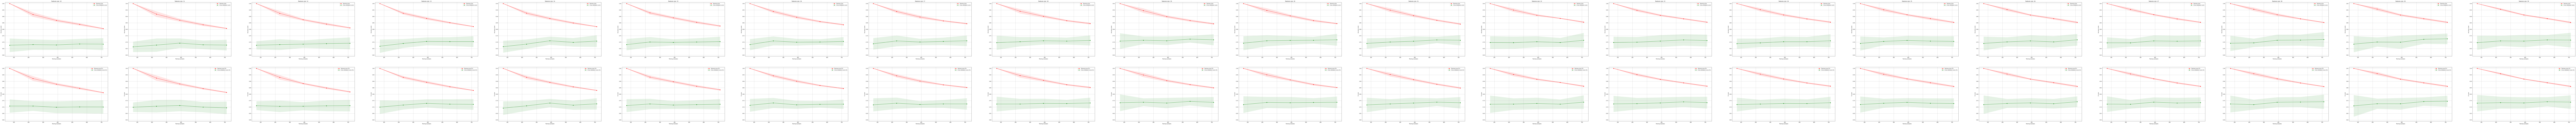

In [29]:
warnings.simplefilter('ignore')

for year in tqdm(range(15, 16, 5)):  # 予後年数毎のループ（時間の都合上、15のみ実験）
    # 特徴量選択から行うので特徴量選択前のデータから使用
    X_train = X_dict["basic"]["train"]["X{0:0=2}".format(year)]
    y_train = y_dict["basic"]["train"]["y{0:0=2}".format(year)]
    min_k = 10
    max_k = 30
    span = 1
    fig, axes = plt.subplots(2, (max_k - min_k) // span + 1, figsize=(22*(max_k-min_k//span+1), 22))
    cv = StratifiedShuffleSplit(n_splits=10, random_state=SEED)
    print('year:',year)

    for k in range(min_k, max_k + 1, span):
        print('-----'*10)
        print('k num: ',k)
        # 特徴量選択するために、trainのデータを抽出
        X_t, _, y_t, _ = train_test_split(X_train, y_train, random_state=SEED, stratify=y_train)
        assert X_t.shape[0] == y_t.shape[0], "train size is incorrect"

        features = mrmr.mrmr_classif(
            X=X_t,
            y=y_t,
            K=k,
            show_progress=False,
        )
        title = "features size: {0}".format(len(features))

        params = {
            "n_estimators": 500,
            "criterion": "entropy",
            "max_depth": 5,
            "max_leaf_nodes": 20,
            "max_features": "log2",
            "class_weight": "balanced",
            "random_state": SEED,
        }
        estimator = RandomForestClassifier(**params)

        # cvをplot_learning_curve内で実施するので、X(y)_trainは使用しない
        plot_learning_curve(
            estimator,
            title,
            X[features],
            y,
            axes=axes[:, (k - min_k)//span],
            ylim=(0.59, 1.01),
            cv=cv,
            n_jobs=4,
            scoring="accuracy",
        )
    make_dir(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR + "/learning_curve/basic/mrmr_detail"
    )
    plt.savefig(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR
        + "/learning_curve/basic/mrmr_detail/X{0:0=2}.png".format(year)
    )

## subtype毎のベースライン・学習

### borutaを使用した場合のベースライン・基本学習結果

In [ ]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    print("====={0:0=2}".format(year) * 10)

    for subtype in pd.read_pickle(
        config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/df_cross.pkl"
    )["CLAUDIN_SUBTYPE"].unique():
        X_train = X_dict["chi2"]["claudin_subtype"]["train"][
            "X{0:0=2}_{1}".format(year, subtype)
        ]
        y_train = y_dict["chi2"]["claudin_subtype"]["train"][
            "y{0:0=2}_{1}".format(year, subtype)
        ]
        X_test = X_dict["chi2"]["claudin_subtype"]["test"][
            "X{0:0=2}_{1}".format(year, subtype)
        ]
        y_test = y_dict["chi2"]["claudin_subtype"]["test"][
            "y{0:0=2}_{1}".format(year, subtype)
        ]
        assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"
        assert X_test.shape[0] == y_test.shape[0], "test size is incorrect"

        # accuracyの表示
        print("----------" * 10)
        print("subtype: ", subtype)
        print("予後年数：{0:0=2}年:".format(year))
        if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
            score = (
                "0>1".format(year),
                round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
            )
        else:
            score = (
                "0>1".format(year),
                round(accuracy_score(y_train, np.ones(len(y_train))), 3),
            )
        print("accuracyベースライン：", score)
        print("使用特徴量：", X_train.columns)
        print("学習サンプルサイズ：", X_train.shape)
        display("ラベル比率：", y_train.value_counts())
        display(compare_bcms(X_train, y_train))

# 最適化

分類器を学習させ、パラメータのチューニングを行い、高い予測精度を目指す。

## optuna

モデルのパラメータをベイズ最適化に基づいて最適化していくoptunaを使用する

### Random Forest

In [ ]:
def objective(trial):
    # ランダムフォレストのパラメータチューニング
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "criterion": trial.suggest_categorical(
            "criterion", ["gini", "entropy", "log_loss"]
        ),
        "max_depth": trial.suggest_int("max_depth", 2, 50, log=True),
        "max_leaf_noddes": trial.suggest_int("max_leaf_nodes", 2, 100),
        "max_features": trial.suggest_categorical(
            "max_features", ["sqrt", "log2", None]
        ),
        "random_state": SEED,
    }

    clf = RandomForestClassifier(**params)
    # 10分割交差検証によるテストデータのaccuracyの出力
    score = cross_val_score(
        clf, X_train, y_train, n_jobs=-1, cv=10, scoring=make_scorer(f1_score)
    )
    accuracy = score.mean()
    return accuracy

In [ ]:
def objective(trial):
    # ロジスティック回帰のパラメータチューニング
    params = {
        "penalty ": "l2",
        "C": trial.suggest_float("C", 1e-5, 100),
        "solver": trial.suggest_categorical(
            "solver", ["newton-cg", "lbfgs", "sag", "saga"]
        ),
        "random_state": SEED,
    }

    clf = LogisticRegression(
        penalty="l2",
        C=C,
        solver=solver,
        random_state=SEED,
    )
    # 10分割交差検証によるテストデータのaccuracyの出力
    score = cross_val_score(
        clf, X_train, y_train, n_jobs=-1, cv=10, scoring=make_scorer(f1_score)
    )
    accuracy = score.mean()
    return accuracy

In [ ]:
def objective(trial):
    # SVMのパラメータチューニング
    params = {
        "C": trial.suggest_float("C", 1e-5, 100),
        "kernel": trial.suggest_categorical(
            "kernel", ["linear", "poly", "rbf", "sigmoid"]
        ),
        "decision_function_shape": trial.suggest_categorical(
            "decision_function_shape", ["ovo", "ovr"]
        ),
    }

    clf = SVC(**params)
    # 10分割交差検証によるテストデータのaccuracyの出力
    score = cross_val_score(
        clf, X_train, y_train, n_jobs=-1, cv=10, scoring=make_scorer(f1_score)
    )
    accuracy = score.mean()
    return accuracy

#### 全サンプルでの予測(boruta)

In [ ]:
year = 15
X_train = X_dict["chi2"]["boruta"]["train"][prognosis_Xlabel]
y_train = y_dict["chi2"]["boruta"]["train"][prognosis_ylabel]
X_test = X_dict["chi2"]["boruta"]["test"][prognosis_Xlabel]
y_test = y_dict["chi2"]["boruta"]["test"][prognosis_ylabel]

study = optuna.create_study(
    direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED)
)
study.optimize(objective, n_trials=100)

In [ ]:
# 最も良いパラメータ
print(f"The best value is : \n {study.best_value}")
print(f"The best parameters are : \n {study.best_params}")

In [20]:
print("tuning前")
rf = RandomForestClassifier(random_state=SEED)
rf.fit(X_train, y_train)
pred_tmp = rf.predict(X_test)
show_scores(y_test, pred_tmp)

print("tuning後")
rf = RandomForestClassifier(
    n_estimators=705,
    criterion="entropy",
    max_depth=2,
    max_leaf_nodes=13,
    max_features="log2",
    random_state=SEED,
)
rf.fit(X_train, y_train)
pred_tmp = rf.predict(X_test)
show_scores(y_test, pred_tmp)

tuning前
accuracy:  0.6317829457364341
precision:  0.6287425149700598
recall:  0.7608695652173914
f1 score:  0.6885245901639344
tuning後
accuracy:  0.6782945736434108
precision:  0.6589595375722543
recall:  0.8260869565217391
f1 score:  0.7331189710610932


## subtype毎の予測

In [23]:
for year in range(5, 16, 5):  # 予後年数毎のループ
    print("====={0:0=2}".format(year) * 10)

    for st in pd.read_pickle(
        config.INTERIM_PICKLE_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/df_cross.pkl"
    )["CLAUDIN_SUBTYPE"].unique():
        print("-----" * 10)
        print(st)
        prognosis_Xlabel = "X{0:0=2}_{1}".format(year, st)
        prognosis_ylabel = "y{0:0=2}_{1}".format(year, st)

        X_train = X_dict["chi2"]["claudin_subtype"]["train"][prognosis_Xlabel]
        y_train = y_dict["chi2"]["claudin_subtype"]["train"][prognosis_ylabel]
        X_test = X_dict["chi2"]["claudin_subtype"]["test"][prognosis_Xlabel]
        y_test = y_dict["chi2"]["claudin_subtype"]["test"][prognosis_ylabel]

        assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"
        assert X_test.shape[0] == y_test.shape[0], "test size is incorrect"

        print("tuning前")
        rf = RandomForestClassifier(random_state=SEED)
        rf.fit(X_train, y_train)
        pred_tmp = rf.predict(X_test)
        show_scores(y_test, pred_tmp)

        print("tuning後")
        rf = RandomForestClassifier(
            n_estimators=705,
            criterion="entropy",
            max_depth=2,
            max_leaf_nodes=13,
            max_features="log2",
            random_state=SEED,
        )
        rf.fit(X_train, y_train)
        pred_tmp = rf.predict(X_test)
        show_scores(y_test, pred_tmp)

=====05=====05=====05=====05=====05=====05=====05=====05=====05=====05
--------------------------------------------------
claudin-low
tuning前
accuracy:  0.7954545454545454
precision:  0.0
recall:  0.0
f1 score:  0.0
tuning後
accuracy:  0.8181818181818182
precision:  0.0
recall:  0.0
f1 score:  0.0
--------------------------------------------------
LumA
tuning前
accuracy:  0.9328859060402684
precision:  0.0
recall:  0.0
f1 score:  0.0
tuning後


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.9328859060402684
precision:  0.0
recall:  0.0
f1 score:  0.0
--------------------------------------------------
LumB
tuning前
accuracy:  0.8173913043478261
precision:  0.0
recall:  0.0
f1 score:  0.0
tuning後


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.8347826086956521
precision:  0.0
recall:  0.0
f1 score:  0.0
--------------------------------------------------
Her2
tuning前
accuracy:  0.6862745098039216
precision:  0.5714285714285714
recall:  0.4444444444444444
f1 score:  0.5
tuning後


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.6470588235294118
precision:  0.5
recall:  0.16666666666666666
f1 score:  0.25
--------------------------------------------------
Normal
tuning前
accuracy:  0.7714285714285715
precision:  0.25
recall:  0.5
f1 score:  0.3333333333333333
tuning後
accuracy:  0.7428571428571429
precision:  0.14285714285714285
recall:  0.25
f1 score:  0.18181818181818182
--------------------------------------------------
Basal
tuning前
accuracy:  0.4523809523809524
precision:  0.3
recall:  0.15789473684210525
f1 score:  0.20689655172413793
tuning後
accuracy:  0.47619047619047616
precision:  0.2857142857142857
recall:  0.10526315789473684
f1 score:  0.15384615384615385
=====10=====10=====10=====10=====10=====10=====10=====10=====10=====10
--------------------------------------------------
claudin-low
tuning前
accuracy:  0.6
precision:  0.375
recall:  0.25
f1 score:  0.3
tuning後
accuracy:  0.6571428571428571
precision:  0.5
recall:  0.16666666666666666
f1 score:  0.25
----------------------------------

/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy:  0.5913978494623656
precision:  0.37037037037037035
recall:  0.3225806451612903
f1 score:  0.3448275862068965
--------------------------------------------------
Her2
tuning前
accuracy:  0.5106382978723404
precision:  0.5
recall:  0.6521739130434783
f1 score:  0.5660377358490566
tuning後
accuracy:  0.5319148936170213
precision:  0.5142857142857142
recall:  0.782608695652174
f1 score:  0.6206896551724138
--------------------------------------------------
Normal
tuning前
accuracy:  0.6666666666666666
precision:  0.4444444444444444
recall:  0.5714285714285714
f1 score:  0.5
tuning後
accuracy:  0.7083333333333334
precision:  0.5
recall:  0.7142857142857143
f1 score:  0.588235294117647
--------------------------------------------------
Basal
tuning前
accuracy:  0.5
precision:  0.6666666666666666
recall:  0.34782608695652173
f1 score:  0.4571428571428571
tuning後
accuracy:  0.5526315789473685
precision:  0.8
recall:  0.34782608695652173
f1 score:  0.48484848484848486
=====15=====15=====15

### lightGBM

In [24]:
from lightgbm import LGBMClassifier


def objective(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "max_bin": trial.suggest_int("max_bin", 100, 300),
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
    }
    clf = LGBMClassifier(boosting_type="gbdt", **params, random_state=SEED)
    # 10分割交差検証によるテストデータのaccuracyの出力
    score = cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=10)
    accuracy = score.mean()
    return accuracy


year = 15
X_train = X_dict["chi2"]["boruta"]["train"]["X{0:0=2}".format(year)]
y_train = y_dict["chi2"]["boruta"]["train"]["y{0:0=2}".format(year)]
X_test = X_dict["chi2"]["boruta"]["test"]["X{0:0=2}".format(year)]
y_test = y_dict["chi2"]["boruta"]["test"]["y{0:0=2}".format(year)]

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2022-08-16 22:31:25,893] A new study created in memory with name: no-name-d85cb0b1-eb61-4dda-8688-2cd171712a05
[I 2022-08-16 22:31:27,395] Trial 0 finished with value: 0.6400030111412225 and parameters: {'lambda_l1': 1.734223168041933e-05, 'lambda_l2': 1.1228551678336792e-07, 'max_bin': 224, 'num_leaves': 38, 'learning_rate': 0.09023530287571588, 'n_estimators': 66}. Best is trial 0 with value: 0.6400030111412225.
[I 2022-08-16 22:31:28,265] Trial 1 finished with value: 0.6436766034327009 and parameters: {'lambda_l1': 0.024522717103743746, 'lambda_l2': 0.001563943840163855, 'max_bin': 143, 'num_leaves': 22, 'learning_rate': 0.004336637489615775, 'n_estimators': 626}. Best is trial 1 with value: 0.6436766034327009.
[I 2022-08-16 22:31:28,517] Trial 2 finished with value: 0.6424269798253538 and parameters: {'lambda_l1': 3.32260152568701e-07, 'lambda_l2': 6.314841123584675e-05, 'max_bin': 140, 'num_leaves': 34, 'learning_rate': 0.0034432967594071524, 'n_estimators': 209}. Best is trial

[LightGBM] [Warning] lambda_l1 is set=1.734223168041933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.734223168041933e-05
[LightGBM] [Warning] lambda_l2 is set=1.1228551678336792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228551678336792e-07
[LightGBM] [Warning] lambda_l1 is set=0.024522717103743746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024522717103743746
[LightGBM] [Warning] lambda_l2 is set=0.001563943840163855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001563943840163855
[LightGBM] [Warning] lambda_l1 is set=0.024522717103743746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024522717103743746
[LightGBM] [Warning] lambda_l2 is set=0.001563943840163855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001563943840163855
[LightGBM] [Warning] lambda_l1 is set=3.32260152568701e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.32260152568701e-07
[LightGBM] [Warning] lambda_l2 i

[I 2022-08-16 22:31:55,993] Trial 64 finished with value: 0.657226738934056 and parameters: {'lambda_l1': 5.556613589209316, 'lambda_l2': 0.0018790721590509962, 'max_bin': 132, 'num_leaves': 23, 'learning_rate': 0.016741615253923346, 'n_estimators': 522}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:31:56,517] Trial 65 finished with value: 0.648584763625414 and parameters: {'lambda_l1': 2.1452059536661876, 'lambda_l2': 0.001902387830817249, 'max_bin': 107, 'num_leaves': 21, 'learning_rate': 0.018380954342557272, 'n_estimators': 578}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:31:56,921] Trial 66 finished with value: 0.6387383318277627 and parameters: {'lambda_l1': 4.4060578786248605, 'lambda_l2': 0.004448702317401843, 'max_bin': 131, 'num_leaves': 23, 'learning_rate': 0.013258137164486395, 'n_estimators': 502}. Best is trial 14 with value: 0.6609454983438723.


[LightGBM] [Warning] lambda_l1 is set=1.734223168041933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.734223168041933e-05
[LightGBM] [Warning] lambda_l2 is set=1.1228551678336792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228551678336792e-07
[LightGBM] [Warning] lambda_l1 is set=1.734223168041933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.734223168041933e-05
[LightGBM] [Warning] lambda_l2 is set=1.1228551678336792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228551678336792e-07
[LightGBM] [Warning] lambda_l1 is set=0.024522717103743746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024522717103743746
[LightGBM] [Warning] lambda_l2 is set=0.001563943840163855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001563943840163855
[LightGBM] [Warning] lambda_l1 is set=3.32260152568701e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.32260152568701e-07
[LightGBM] [Warning] lambd

[I 2022-08-16 22:31:57,825] Trial 67 finished with value: 0.6387684432399879 and parameters: {'lambda_l1': 0.447316449969109, 'lambda_l2': 0.025181933697597917, 'max_bin': 143, 'num_leaves': 25, 'learning_rate': 0.016356025622907767, 'n_estimators': 631}. Best is trial 14 with value: 0.6609454983438723.


[LightGBM] [Warning] lambda_l1 is set=1.734223168041933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.734223168041933e-05
[LightGBM] [Warning] lambda_l2 is set=1.1228551678336792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228551678336792e-07
[LightGBM] [Warning] lambda_l1 is set=1.734223168041933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.734223168041933e-05
[LightGBM] [Warning] lambda_l2 is set=1.1228551678336792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228551678336792e-07
[LightGBM] [Warning] lambda_l1 is set=0.024522717103743746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024522717103743746
[LightGBM] [Warning] lambda_l2 is set=0.001563943840163855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001563943840163855
[LightGBM] [Warning] lambda_l1 is set=0.024522717103743746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024522717103743746
[LightGBM] [Warning] lambd

[I 2022-08-16 22:31:58,328] Trial 68 finished with value: 0.6461607949412828 and parameters: {'lambda_l1': 1.1467411799207328, 'lambda_l2': 1.34920811434988e-06, 'max_bin': 121, 'num_leaves': 23, 'learning_rate': 0.008496867917375606, 'n_estimators': 435}. Best is trial 14 with value: 0.6609454983438723.


[LightGBM] [Warning] lambda_l1 is set=1.734223168041933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.734223168041933e-05
[LightGBM] [Warning] lambda_l2 is set=1.1228551678336792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228551678336792e-07
[LightGBM] [Warning] lambda_l1 is set=0.024522717103743746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024522717103743746
[LightGBM] [Warning] lambda_l2 is set=0.001563943840163855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001563943840163855
[LightGBM] [Warning] lambda_l1 is set=3.32260152568701e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.32260152568701e-07
[LightGBM] [Warning] lambda_l2 is set=6.314841123584675e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.314841123584675e-05
[LightGBM] [Warning] lambda_l1 is set=0.00027788728282719395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00027788728282719395
[LightGBM] [Warning] lambd

[I 2022-08-16 22:31:58,708] Trial 69 finished with value: 0.6498343872327613 and parameters: {'lambda_l1': 4.719644468580365, 'lambda_l2': 0.8649354690700519, 'max_bin': 269, 'num_leaves': 26, 'learning_rate': 0.02577738570990105, 'n_estimators': 535}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:31:58,992] Trial 70 finished with value: 0.6473803071364046 and parameters: {'lambda_l1': 2.5768527346561516, 'lambda_l2': 0.0015865824636203763, 'max_bin': 135, 'num_leaves': 21, 'learning_rate': 0.03903296704223069, 'n_estimators': 481}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:31:59,193] Trial 71 finished with value: 0.6473652514302921 and parameters: {'lambda_l1': 6.129773915848572, 'lambda_l2': 9.045527068871285e-05, 'max_bin': 160, 'num_leaves': 25, 'learning_rate': 0.030685285978769038, 'n_estimators': 515}. Best is trial 14 with value: 0.6609454983438723.


[LightGBM] [Warning] lambda_l1 is set=1.734223168041933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.734223168041933e-05
[LightGBM] [Warning] lambda_l2 is set=1.1228551678336792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228551678336792e-07
[LightGBM] [Warning] lambda_l1 is set=0.024522717103743746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024522717103743746
[LightGBM] [Warning] lambda_l2 is set=0.001563943840163855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001563943840163855
[LightGBM] [Warning] lambda_l1 is set=3.32260152568701e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.32260152568701e-07
[LightGBM] [Warning] lambda_l2 is set=6.314841123584675e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.314841123584675e-05
[LightGBM] [Warning] lambda_l1 is set=3.32260152568701e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.32260152568701e-07
[LightGBM] [Warning] lambda_l2

[I 2022-08-16 22:31:59,300] Trial 72 finished with value: 0.6535079795242396 and parameters: {'lambda_l1': 8.648652987098556, 'lambda_l2': 0.0004443516803547056, 'max_bin': 127, 'num_leaves': 27, 'learning_rate': 0.0447476724047812, 'n_estimators': 408}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:31:59,631] Trial 73 finished with value: 0.6485998193315267 and parameters: {'lambda_l1': 2.5701721123843484, 'lambda_l2': 0.00017470740253171954, 'max_bin': 149, 'num_leaves': 23, 'learning_rate': 0.03255895387915341, 'n_estimators': 380}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:31:59,905] Trial 74 finished with value: 0.6523185787413429 and parameters: {'lambda_l1': 1.3867990806806856, 'lambda_l2': 0.0007660183301715951, 'max_bin': 140, 'num_leaves': 21, 'learning_rate': 0.056631547120694355, 'n_estimators': 347}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:32:00,064] Trial 75 finished with value: 0.6510538994278832 and p

[LightGBM] [Warning] lambda_l1 is set=1.734223168041933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.734223168041933e-05
[LightGBM] [Warning] lambda_l2 is set=1.1228551678336792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228551678336792e-07
[LightGBM] [Warning] lambda_l1 is set=0.024522717103743746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024522717103743746
[LightGBM] [Warning] lambda_l2 is set=0.001563943840163855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001563943840163855
[LightGBM] [Warning] lambda_l1 is set=3.32260152568701e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.32260152568701e-07
[LightGBM] [Warning] lambda_l2 is set=6.314841123584675e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.314841123584675e-05
[LightGBM] [Warning] lambda_l1 is set=0.00027788728282719395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00027788728282719395
[LightGBM] [Warning] lambd

[I 2022-08-16 22:32:00,815] Trial 76 finished with value: 0.644896115627823 and parameters: {'lambda_l1': 0.5195001805497436, 'lambda_l2': 2.019404472054531e-05, 'max_bin': 231, 'num_leaves': 41, 'learning_rate': 0.028871027566561513, 'n_estimators': 418}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:32:00,931] Trial 77 finished with value: 0.6522583559168924 and parameters: {'lambda_l1': 9.707135307691265, 'lambda_l2': 0.009830260491590272, 'max_bin': 154, 'num_leaves': 24, 'learning_rate': 0.036444830426897154, 'n_estimators': 458}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:32:01,805] Trial 78 finished with value: 0.6486148750376393 and parameters: {'lambda_l1': 0.0007362179029109824, 'lambda_l2': 0.0038496945405166287, 'max_bin': 160, 'num_leaves': 27, 'learning_rate': 0.023670256034270247, 'n_estimators': 557}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:32:02,710] Trial 79 finished with value: 0.6436916591388135 an

[LightGBM] [Warning] lambda_l1 is set=1.734223168041933e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.734223168041933e-05
[LightGBM] [Warning] lambda_l2 is set=1.1228551678336792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1228551678336792e-07
[LightGBM] [Warning] lambda_l1 is set=0.024522717103743746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024522717103743746
[LightGBM] [Warning] lambda_l2 is set=0.001563943840163855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001563943840163855
[LightGBM] [Warning] lambda_l1 is set=3.32260152568701e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.32260152568701e-07
[LightGBM] [Warning] lambda_l2 is set=6.314841123584675e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.314841123584675e-05
[LightGBM] [Warning] lambda_l1 is set=0.00027788728282719395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00027788728282719395
[LightGBM] [Warning] lambd

[I 2022-08-16 22:32:03,103] Trial 81 finished with value: 0.6497892201144233 and parameters: {'lambda_l1': 1.122187495351106, 'lambda_l2': 3.744412738692583e-05, 'max_bin': 175, 'num_leaves': 43, 'learning_rate': 0.006669244922140303, 'n_estimators': 200}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:32:03,428] Trial 82 finished with value: 0.6535531466425775 and parameters: {'lambda_l1': 2.814070259090271, 'lambda_l2': 3.921092362620511e-05, 'max_bin': 165, 'num_leaves': 47, 'learning_rate': 0.026316158904018935, 'n_estimators': 313}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:32:03,725] Trial 83 finished with value: 0.6461306835290574 and parameters: {'lambda_l1': 0.7607491638412529, 'lambda_l2': 1.3912084113077726e-05, 'max_bin': 152, 'num_leaves': 45, 'learning_rate': 0.04315835338374708, 'n_estimators': 222}. Best is trial 14 with value: 0.6609454983438723.
[I 2022-08-16 22:32:04,040] Trial 84 finished with value: 0.6448660042155976 and 

In [25]:
# 最も良いパラメータ
print(f"The best value is : \n {study.best_value}")
print(f"The best parameters are : \n {study.best_params}")

The best value is : 
 0.6609454983438723
The best parameters are : 
 {'lambda_l1': 7.092425834276755, 'lambda_l2': 0.00375647656197759, 'max_bin': 155, 'num_leaves': 27, 'learning_rate': 0.023055145734020118, 'n_estimators': 371}
[LightGBM] [Warning] lambda_l1 is set=6.794787897999373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.794787897999373
[LightGBM] [Warning] lambda_l2 is set=1.2156868064319407e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2156868064319407e-08
[LightGBM] [Warning] lambda_l1 is set=1.8445393277819262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8445393277819262
[LightGBM] [Warning] lambda_l2 is set=0.001162357381469733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001162357381469733
[LightGBM] [Warning] lambda_l1 is set=1.8445393277819262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8445393277819262
[LightGBM] [Warning] lambda_l2 is set=0.001162357381469733, reg_lambda=0.0 will be ignored. C